### Libraries

In [298]:
import os
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import numpy as np
import squarify
import textwrap
import re
import numpy as np
from math import sqrt
from scipy.stats import norm
import scipy.stats as stats
from scipy.stats import ttest_ind

### Data dictionary




###### TRANSACTION DATE: Date of purchase
###### CARD POSTING DATE: Date purchase posted by credit card company
###### MERCHANT NAME: Name of vendor where purchase was made
###### TRANSACTION AMOUNT: Amount of purchase in Canadian currency (including amounts after conversion from other currencies)
###### TRANSACTION CURRENCY: Currency of country
###### ORIGINAL AMOUNT:	Amount of Purchase in the currency of purchase (pre-exchange)
###### ORIGINAL CURRENCY: Currency in which purchase was made
###### G/L ACCOUNT:	Description of the type of expense made and to be recorded
###### G/L ACCOUNT DESCRIPTION:	Long text description of the expense
###### COST CENTRE/WBS ELEMENT/ORDER: Represents the Organization Unit or the "where" a Division/Program tracks its revenues and expenditures
###### COST CENTRE/WBS ELEMENT/ORDER DESCRIPTION: Description of the Organization Unit or the "where" a Division/Program recorded its expenditure
###### MERCHANT TYPE (MCC):	A four-digit number assigned by MasterCard and VISA to a merchant. The MCC is used to classify the business by goods/services it provides.
###### MERCHANT TYPE DESCRIPTION: Description of the MCC assigned to the merchant
###### PURPOSE:	Free-form text describing purchase by the cardholder

### Load the files
Use a loop to get only the last 24 months available to analyze two years of data

In [124]:
# Path where your CSVs are stored
folder_path = r"C:\\Users\\Ivan Kenigsberg\\Desktop\\Northeastern University\\ALY 6010\\Final Project\\pcard-expenses"

# Define date range
start_date, end_date = 202305, 202504

# List and filter files
files = [
    f for f in os.listdir(folder_path)
    if f.startswith("PCardExpenses_")
    and f.lower().endswith((".xls", ".xlsx"))
    and start_date <= int(f.split("_")[1].split(".")[0]) <= end_date
]

files.sort()
print(f"Found {len(files)} files, which go from {start_date} to {end_date}")

# Read and combine
df_list = []
for f in files:
    warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")
    path = os.path.join(folder_path, f)
    df = pd.read_excel(path)
    df.columns = (
        df.columns
          .astype(str)                         # ensure all are strings
          .str.strip()                         # remove spaces before/after
          .str.replace(r"\s+", " ", regex=True) # collapse multiple spaces
    )
    df["source_file"] = f
    df_list.append(df)

combined_df = pd.concat(df_list, ignore_index=True)

print(f"Those {len(files)} were combined, there are total {len(combined_df)} rows")

Found 24 files, which go from 202305 to 202504
Those 24 were combined, there are total 179876 rows


### Perform a data quality check

In [125]:
# Check the shape (rows, columns)
print("Shape:", combined_df.shape)

# Count empty (NaN) cells per column
print("\nMissing values per column:")
print(combined_df.isna().sum())


Shape: (179876, 17)

Missing values per column:
Division                                         28457
Batch-Transaction ID                             28451
Transaction Date                                 28451
Card Posting Dt                                  28451
Merchant Name                                    28451
Transaction Amt.                                  1346
Trx.Currency                                      1346
Original Amount                                      6
Original Currency                                    6
G/L Account                                      28508
G/L Account Description                          28451
Cost Center / WBS Element / Order                28486
Cost Center / WBS Element / Order Description    34085
Merchant Type                                    28453
Merchant Type Description                        28451
Purpose                                          28457
source_file                                          0
dtype: int64


In [126]:
rows_before = len(combined_df)

# Remove rows where 'Batch-Transaction ID' is missing or blank
clean_combined_df = combined_df[combined_df['Batch-Transaction ID'].notna()]

rows_after = len(clean_combined_df)

print(f"Removed {rows_before - rows_after} rows with empty 'Batch-Transaction ID'")
print(f"Remaining rows: {rows_after}")

Removed 28451 rows with empty 'Batch-Transaction ID'
Remaining rows: 151425


In [127]:
# Check the shape (rows, columns)
print("Shape:", clean_combined_df.shape)

# Count empty (NaN) cells per column
print("\nMissing values per column:")
print(clean_combined_df.isna().sum())


Shape: (151425, 17)

Missing values per column:
Division                                            6
Batch-Transaction ID                                0
Transaction Date                                    0
Card Posting Dt                                     0
Merchant Name                                       0
Transaction Amt.                                    0
Trx.Currency                                        0
Original Amount                                     0
Original Currency                                   0
G/L Account                                        57
G/L Account Description                             0
Cost Center / WBS Element / Order                  35
Cost Center / WBS Element / Order Description    5634
Merchant Type                                       2
Merchant Type Description                           0
Purpose                                             7
source_file                                         0
dtype: int64


In [128]:
clean_combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151425 entries, 0 to 179870
Data columns (total 17 columns):
 #   Column                                         Non-Null Count   Dtype         
---  ------                                         --------------   -----         
 0   Division                                       151419 non-null  object        
 1   Batch-Transaction ID                           151425 non-null  object        
 2   Transaction Date                               151425 non-null  datetime64[ns]
 3   Card Posting Dt                                151425 non-null  datetime64[ns]
 4   Merchant Name                                  151425 non-null  object        
 5   Transaction Amt.                               151425 non-null  float64       
 6   Trx.Currency                                   151425 non-null  object        
 7   Original Amount                                151425 non-null  float64       
 8   Original Currency                              15

In [129]:
clean_combined_df.head(5)

,Division,Batch-Transaction ID,Transaction Date,Card Posting Dt,Merchant Name,Transaction Amt.,Trx.Currency,Original Amount,Original Currency,G/L Account,G/L Account Description,Cost Center / WBS Element / Order,Cost Center / WBS Element / Order Description,Merchant Type,Merchant Type Description,Purpose,source_file
0,TORONTO PARAMEDIC SERVICES,6338-1,2023-04-27,2023-05-01,C/O OXFORD TRUCK STOP,100.00,CAD,100.00,CAD,2260,GASOLINE,B41000,OPERATION&MAINTENANCE OF GARAGE,5542.0,"Fuel Dispenser, Automated",FUEL 64.144L @$1.559/L,PCardExpenses_202305.xlsx
2,SOLID WASTE MANAGEMENT,6344-1,2023-05-05,2023-05-08,LONDON ESSO FUEL CENTR,120.00,CAD,120.00,CAD,2260,GASOLINE,SW0901,GREEN LANE LANDFILL,5541.0,Service Stations (with or without Ancill,FUEL PURCHASE,PCardExpenses_202305.xlsx
4,FIRE SERVICES,6357-1,2023-05-23,2023-05-25,SAYAL ELECTRONICS (TOR,25.88,CAD,25.88,CAD,2575,ELECTRICAL SUPPLIES,FR0025,MECHANICAL MAINT-VEHICLE MAINT,5732.0,Electronic Sales,TRAVEL ADAPTER FOR BRONTO TRAINING SIMULATOR,PCardExpenses_202305.xlsx
5,FIRE SERVICES,6357-2,2023-05-23,2023-05-25,MTO RUS-SO NORTH YORK,118.00,CAD,118.00,CAD,4830,PERMIT & LICENSE FEES,FR0025,MECHANICAL MAINT-VEHICLE MAINT,9399.0,Government Services - Not Elsewhere Clas,REPLACEMENT PLATES - UNITS 25054 AND 24152,PCardExpenses_202305.xlsx
6,FIRE SERVICES,6360-1,2023-05-29,2023-05-30,DEPENDABLE TRUCK AND T,1210.00,CAD,1210.00,CAD,*****,PERMIT & LICENSE FEES,*****,MULTIPLE COST CENTRES,5511.0,"Automobile and Truck Dealers - Sales, Se",**MORE** SPEED ENFORCEMENT & RED LIGHT TICKET...,PCardExpenses_202305.xlsx


### Data cleaning

In [130]:
clean_combined_df = clean_combined_df.drop(columns=["Card Posting Dt", "G/L Account", "Cost Center / WBS Element / Order","Cost Center / WBS Element / Order Description"])

In [131]:
clean_combined_df = clean_combined_df.rename(columns={
    "Division": "division",
    "Batch-Transaction ID": "trx_id",
    "Transaction Date": "trx_dt",
    "Merchant Name": "merchant_name",
    "Transaction Amt.": "trx_amt",
    "Trx.Currency": "trx_currency",
    "Original Amount": "original_amt",
    "Original Currency": "original_currency",
    "G/L Account": "gl_account",
    "G/L Account Description": "gl_account_desc",
    "Merchant Type": "merchant_type",
    "Merchant Type Description": "merchant_type_desc",
    "Purpose": "purpose"
})

In [132]:
clean_combined_df["merchant_type"] = clean_combined_df["merchant_type"].astype("category")

In [133]:
clean_combined_df["year_month"] = clean_combined_df["trx_dt"].dt.strftime("%Y-%m")
clean_combined_df["month_num"] = clean_combined_df["trx_dt"].dt.month
clean_combined_df["month_name"] = clean_combined_df["trx_dt"].dt.strftime("%B")



In [134]:
clean_combined_df.duplicated().any()


np.False_

### Summary statistics

In [135]:
clean_combined_df.describe().round(0).T

,count,mean,min,25%,50%,75%,max,std
trx_dt,151425,2024-04-27 10:44:58.413075712,2023-04-18 00:00:00,2023-10-25 00:00:00,2024-05-03 00:00:00,2024-10-23 00:00:00,2025-04-30 00:00:00,NaN
trx_amt,151425.0,333.0,-8493.0,38.0,103.0,297.0,53946.0,839.0
original_amt,151425.0,330.0,-8493.0,38.0,103.0,294.0,53946.0,833.0
month_num,151425.0,7.0,1.0,4.0,7.0,9.0,12.0,3.0


In [136]:
clean_combined_df.describe(include='O').T


,count,unique,top,freq
division,151419,81,"PARKS, FORESTRY & RECREATION",65457
trx_id,151425,151019,6772-1,2
merchant_name,151425,33219,ONLAND(S),3804
trx_currency,151425,1,CAD,151425
original_currency,151425,10,CAD,148796
gl_account_desc,151425,317,RECREATIONAL & EDUCATIONAL SUPPLIES,25979
merchant_type_desc,151425,295,Computer Network/Information Services,20747
purpose,151418,95262,Title search,1873
source_file,151425,24,PCardExpenses_202405.xlsx,7116
year_month,151425,25,2024-05,7086


In [137]:
# Check the shape (rows, columns)
print("Shape:", clean_combined_df.shape)

# Count empty (NaN) cells per column
print("\nMissing values per column:")
print(clean_combined_df.isna().sum())


Shape: (151425, 16)

Missing values per column:
division              6
trx_id                0
trx_dt                0
merchant_name         0
trx_amt               0
trx_currency          0
original_amt          0
original_currency     0
gl_account_desc       0
merchant_type         2
merchant_type_desc    0
purpose               7
source_file           0
year_month            0
month_num             0
month_name            0
dtype: int64


Create a copy of the cleand data frame as this is the one that I will be using from now on

In [138]:
final_df = clean_combined_df.copy()

### Data visualization for variables exploration

#### Numerical variables

In [139]:
def hist_boxplot(var, log_scale=False):
    """Creates a histogram and boxplot for a given variable in a DataFrame, with optional log scale."""

    plt.figure(figsize=(12, 6))

    # Histogram
    plt.subplot(1, 2, 1)
    data = final_df[var].dropna()

    sns.histplot(data, bins=30, edgecolor='black')
    plt.title(f"Histogram of {var}")
    plt.xlabel(var)
    plt.ylabel("Count")

    if log_scale:
        plt.xscale("log")  # apply log scale to x-axis

    # Boxplot (vertical)
    plt.subplot(1, 2, 2)
    sns.boxplot(y=data)
    plt.title(f"Boxplot of {var}")
    plt.ylabel(var)

    if log_scale:
        plt.yscale("log")  # apply log scale to y-axis

    plt.tight_layout()
    plt.show()


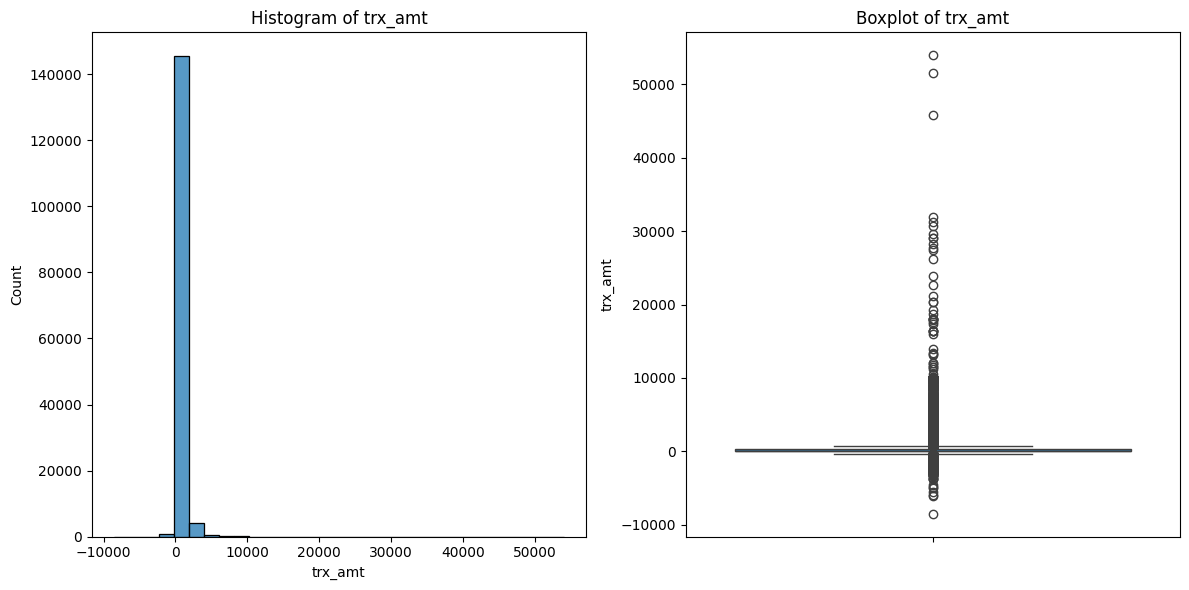

In [140]:
hist_boxplot('trx_amt')

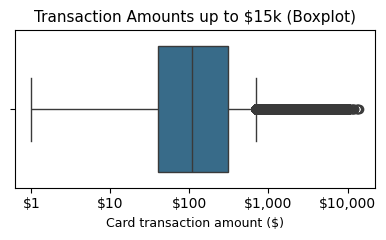

In [285]:
### Visualization for slide deck
plt.figure(figsize=(4,2.5))

subset = final_df[(final_df['trx_amt'] >= 1) & (final_df['trx_amt'] <= 15000)]['trx_amt']

sns.boxplot(
    x=subset,
    color="#2A6F97",
    linewidth=1
)

plt.xscale('log')

# Remove minor ticks (the small lines)
plt.gca().xaxis.set_minor_locator(mtick.NullLocator())

plt.title("Transaction Amounts up to $15k (Boxplot)", fontsize=11)
plt.xlabel("Card transaction amount ($)", fontsize=9)

# Clean major ticks
xticks = [1, 10, 100, 1000, 10000]
plt.xticks(xticks)
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${int(x):,}'))

plt.tight_layout()
plt.show()

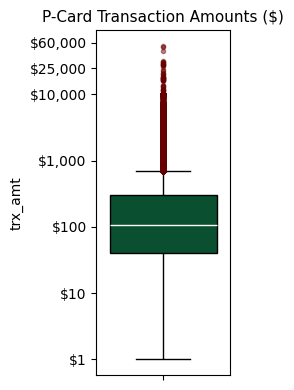

In [287]:
### Visualization for slide deck
plt.figure(figsize=(2.5,4))

subset = final_df[(final_df['trx_amt'] >= 1) & 
                  (final_df['trx_amt'] <= 60000)]['trx_amt']

sns.boxplot(
    y=subset,
    boxprops=dict(facecolor="#0A4F2F", edgecolor="black"),   # green box, black border
    whiskerprops=dict(color="black"),                        # black whiskers
    capprops=dict(color="black"),                            # black caps
    medianprops=dict(color="white"),                         # white median line
    flierprops=dict(
        marker='o',
        markersize=3,
        markerfacecolor="#660000",                           # darker red
        markeredgecolor="#660000",
        alpha=0.45                                           # transparency to reduce clutter
    )
)

plt.yscale('log')

# Remove minor ticks
plt.gca().yaxis.set_minor_locator(mtick.NullLocator())

plt.title("P-Card Transaction Amounts ($)", fontsize=11)

# Clean major ticks
yticks = [1, 10, 100, 1000, 10000, 25000, 60000]
plt.yticks(yticks)
plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f'${int(x):,}')
)

plt.tight_layout()
plt.show()


In [143]:
final_df['trx_amt'].max()

np.float64(53946.2)

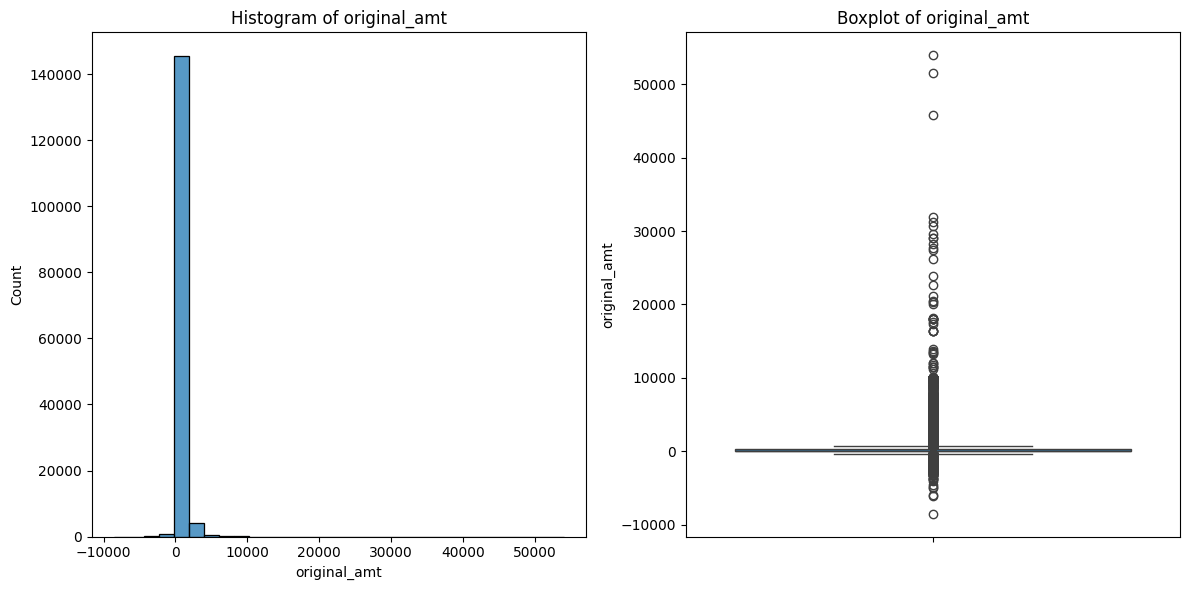

In [144]:
hist_boxplot('original_amt')

Original amount and transaction amount are very similar. But I need to use a log scale to be able to make sense of the data visualization.

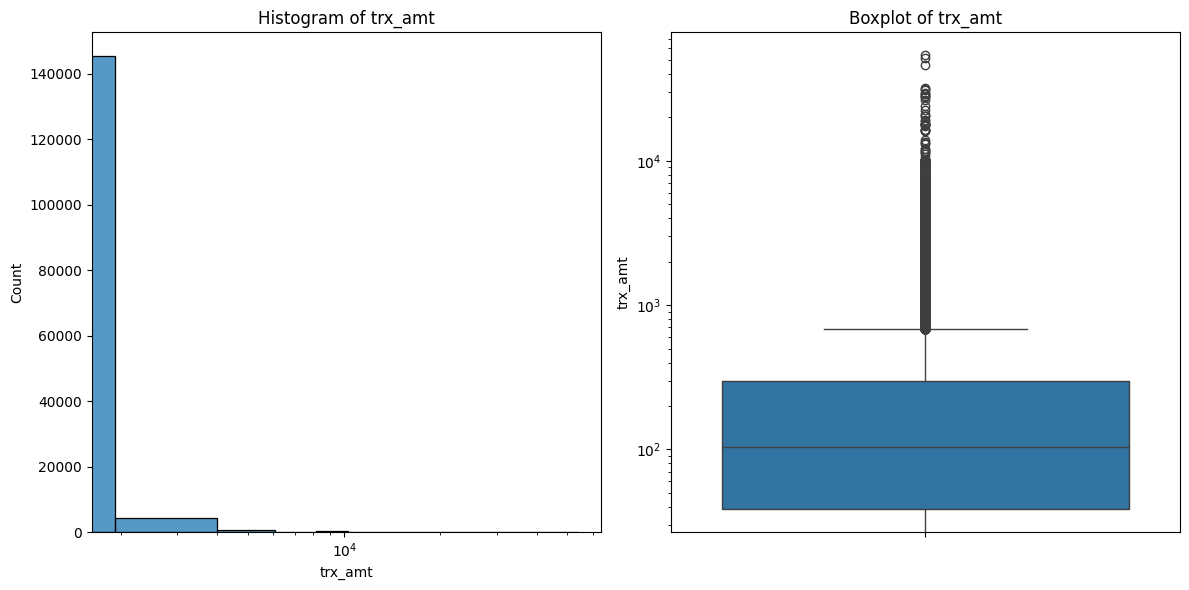

In [145]:
hist_boxplot("trx_amt", log_scale=True) 

In [146]:
final_df["trx_amt"].agg(["sum","mean", "median"])

sum       5.042313e+07
mean      3.329908e+02
median    1.033700e+02
Name: trx_amt, dtype: float64

In [147]:
final_df["original_amt"].agg(["mean", "median"])

mean      330.133639
median    102.690000
Name: original_amt, dtype: float64

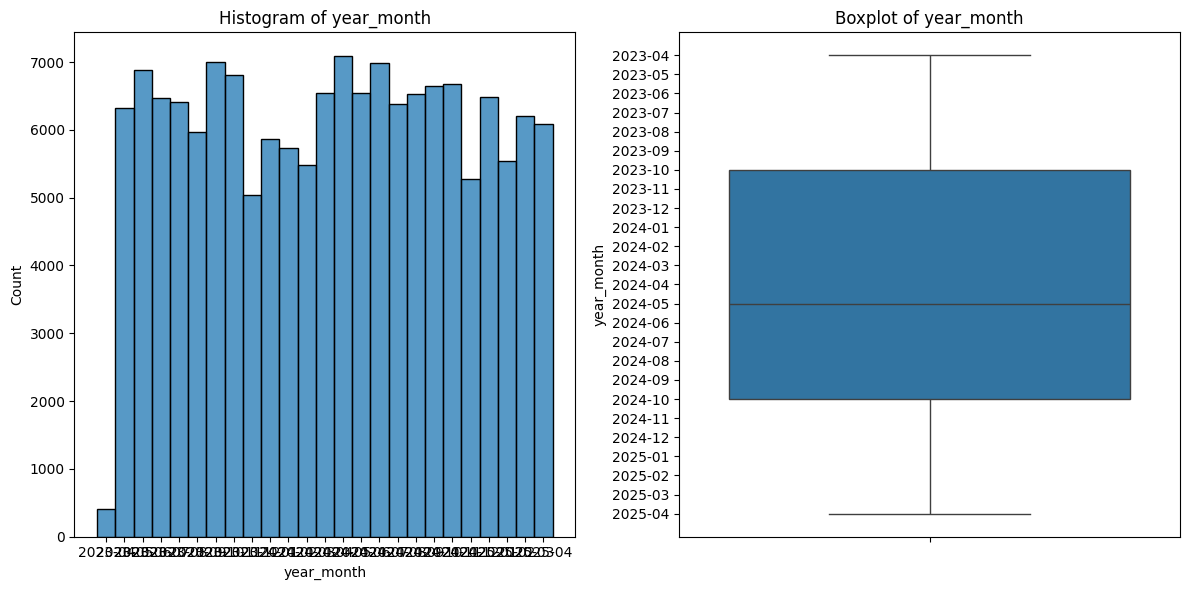

In [148]:
hist_boxplot("year_month", log_scale=False) 

In [149]:
trx_count_by_month = final_df.groupby("year_month")["trx_amt"].count()
trx_amount_by_month = final_df.groupby("year_month")["trx_amt"].sum()


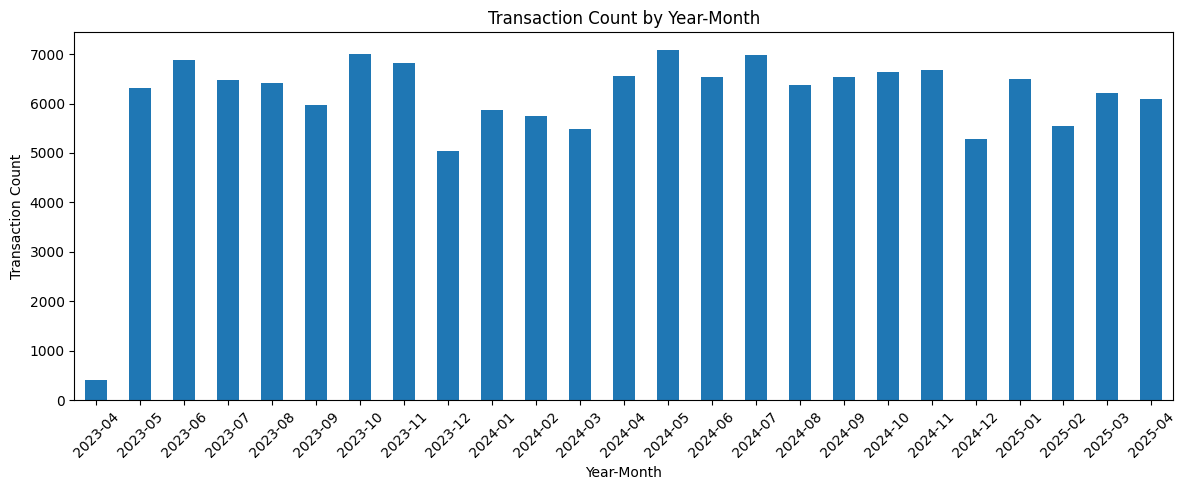

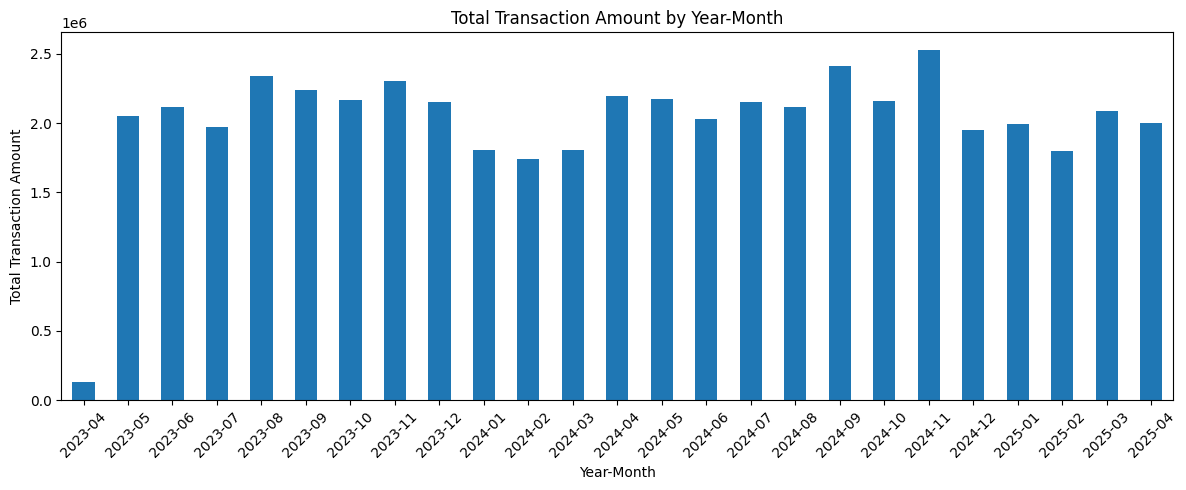

In [150]:
# --- Bar Chart: Transaction Count ---
plt.figure(figsize=(12, 5))
trx_count_by_month.plot(kind="bar")
plt.title("Transaction Count by Year-Month")
plt.xlabel("Year-Month")
plt.ylabel("Transaction Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Bar Chart: Total Transaction Amount ---
plt.figure(figsize=(12, 5))
trx_amount_by_month.plot(kind="bar")
plt.title("Total Transaction Amount by Year-Month")
plt.xlabel("Year-Month")
plt.ylabel("Total Transaction Amount")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


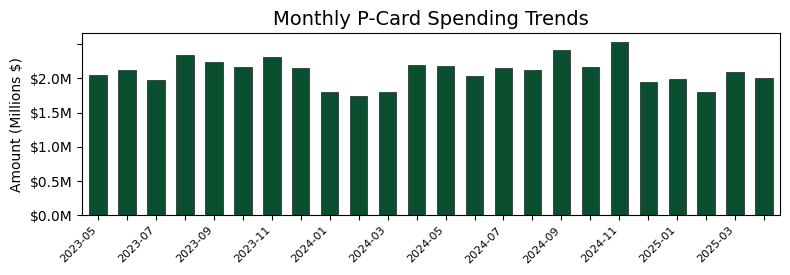

In [288]:
### Visualization for slide deck
# --- Remove 2023-04 ---
filtered = trx_amount_by_month.drop(labels=["2023-04"], errors="ignore")

plt.figure(figsize=(8, 3))  # Narrow size for PPT

ax = filtered.plot(
    kind="bar",
    color="#0A4F2F",          # <-- your dark green
    edgecolor="black",
    linewidth=0.4,
    width=0.6                
)

# --- Keep main title, remove subtitle ---
plt.title("Monthly P-Card Spending Trends", fontsize=14)
plt.suptitle("")  # Remove subtitle only

# --- Axis labels ---
plt.xlabel("")
plt.ylabel("Amount (Millions $)", fontsize=10)

# --- X-axis labels cleanup ---
plt.xticks(rotation=45, ha="right", fontsize=8)

# Show every second label only
for i, label in enumerate(ax.xaxis.get_ticklabels()):
    if i % 2 != 0:
        label.set_visible(False)

# --- Format y-axis in millions ---
ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, pos: f'${x/1_000_000:.1f}M')
)

# --- Remove the 2.5M label specifically ---
for label in ax.get_yticklabels():
    if "2.5" in label.get_text():
        label.set_visible(False)

# --- Remove gridlines ---
plt.grid(False)

plt.tight_layout()
plt.show()


There are no clear seasonal patterns in monthly activity, but November consistently stands out with a noticeable spike. This repeated increase may reflect year-end behaviors that warrant closer review.


#### Categorical variables

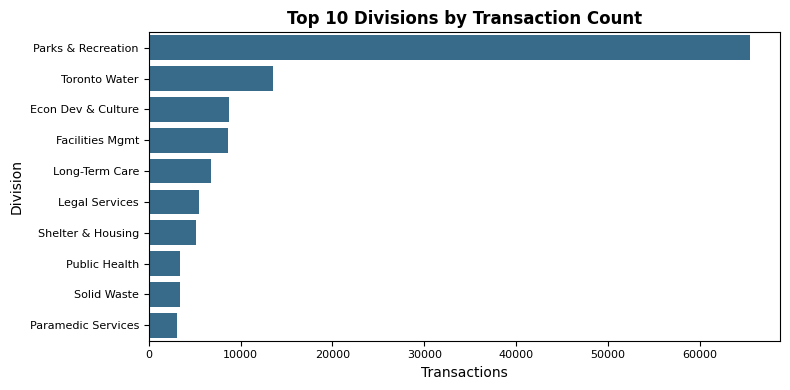

In [289]:
# Data
top_divisions = final_df['division'].value_counts().head(10)

# Shorten long names for PPT readability
short_names = {
    "PARKS, FORESTRY & RECREATION": "Parks & Recreation",
    "TORONTO WATER": "Toronto Water",
    "ECONOMIC DEVELOPMENT & CULTURE": "Econ Dev & Culture",
    "FACILITIES MANAGEMENT": "Facilities Mgmt",
    "LONG-TERM CARE HOMES & SERVICES": "Long-Term Care",
    "LEGAL SERVICES": "Legal Services",
    "SHELTER, SUPPORT & HOUSING ADMINSTRATION": "Shelter & Housing",
    "PUBLIC HEALTH": "Public Health",
    "SOLID WASTE MANAGEMENT": "Solid Waste",
    "TORONTO PARAMEDIC SERVICES": "Paramedic Services"
}

labels = [short_names.get(name, name) for name in top_divisions.index]

# Plot
plt.figure(figsize=(8, 4))  # Smaller chart for PPT

sns.barplot(
    x=top_divisions.values,
    y=labels,
    color="#2A6F97"
)

plt.title("Top 10 Divisions by Transaction Count", fontsize=12, weight="bold")
plt.xlabel("Transactions", fontsize=10)
plt.ylabel("Division", fontsize=10)

# Reduce tick label size
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Tight layout for PPT
plt.tight_layout()
plt.show()



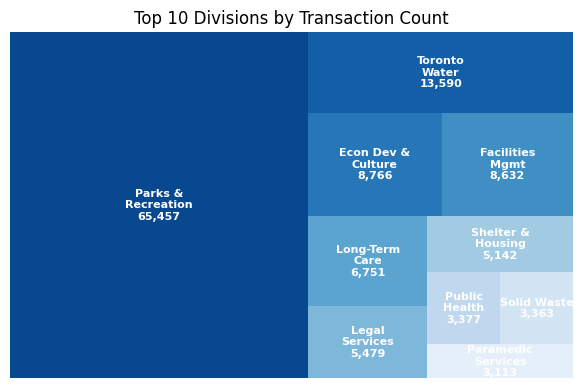

In [290]:
def wrap_label(text, width=12):
    import textwrap
    return "\n".join(textwrap.wrap(text, width=width))

# labels & top_divisions as you already have them

colors = sns.color_palette("Blues_r", len(labels))

wrapped_labels = [
    f"{wrap_label(label)}\n{value:,}"
    for label, value in zip(labels, top_divisions.values)
]

plt.figure(figsize=(6, 4))

squarify.plot(
    sizes=top_divisions.values,
    label=wrapped_labels,
    color=colors,
    text_kwargs={'fontsize': 8, 'color': 'white', 'weight': 'bold'},
)

# 👇 This flips the rectangles vertically,
# sending the smallest ones to the bottom-right
ax = plt.gca()
ax.invert_yaxis()

plt.title("Top 10 Divisions by Transaction Count", fontsize=12)
plt.axis('off')
plt.tight_layout()
plt.show()




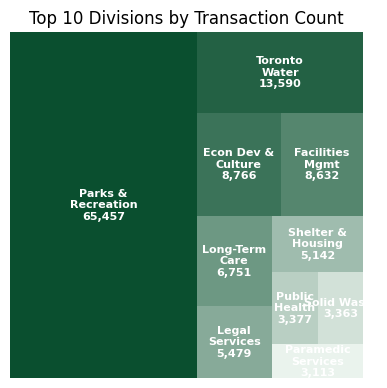

In [291]:
def wrap_label(text, width=12):
    return "\n".join(textwrap.wrap(text, width=width))

# Create a green palette, darkest = your color
dark_green = "#0A4F2F"

# Generate lighter greens using blend between your dark color and white
palette = sns.light_palette(dark_green, n_colors=len(top_divisions), reverse=True)

# Prepare wrapped labels
wrapped_labels = [
    f"{wrap_label(label)}\n{value:,}"
    for label, value in zip(labels, top_divisions.values)
]

plt.figure(figsize=(4, 4))

squarify.plot(
    sizes=top_divisions.values,
    label=wrapped_labels,
    color=palette,
    text_kwargs={'fontsize': 8, 'color': 'white', 'weight': 'bold'},
)

# Place smaller divisions at bottom-right
ax = plt.gca()
ax.invert_yaxis()

plt.title("Top 10 Divisions by Transaction Count", fontsize=12)
plt.axis('off')
plt.tight_layout()
plt.show()


In [155]:
# Create a summary table: division, count of transactions, and total transaction amount
division_summary = (
    final_df.groupby('division')
    .agg(
        transaction_count = ('trx_amt', 'count'),
        total_amount = ('trx_amt', 'sum')
    )
    .sort_values(by='transaction_count', ascending=False)
)

# Display the top 15 divisions
division_summary

,transaction_count,total_amount
division,,
"PARKS, FORESTRY & RECREATION",65457,16672712.77
TORONTO WATER,13590,5313345.10
ECONOMIC DEVELOPMENT & CULTURE,8766,2863684.96
FACILITIES MANAGEMENT,8632,2431364.46
LONG-TERM CARE HOMES & SERVICES,6751,1713433.08
...,...,...
"EQUITY, DIVERSITY AND HUMAN RIGHTS OFFICE",7,9531.30
DEVELOPMENT & GROWTH SERVICES,6,2528.25
OFFICE OF CHIEF INFORMATION SECURITY,5,282.40


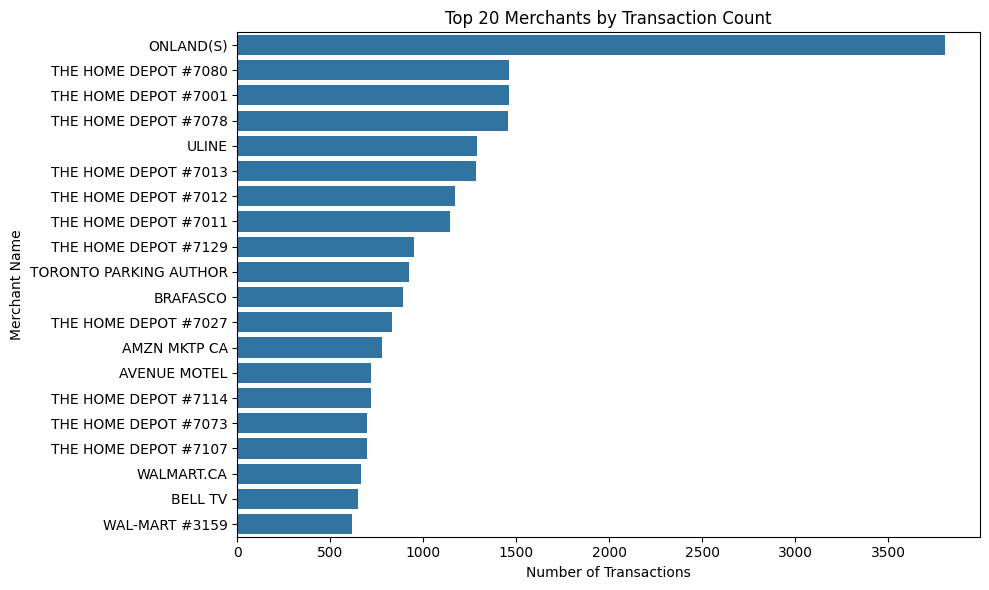

In [156]:
##Merchant Name — Top 20 Most Frequent Merchants
plt.figure(figsize=(10,6))
top_merchants = final_df['merchant_name'].value_counts().head(20)

sns.barplot(x=top_merchants.values, y=top_merchants.index)
plt.title("Top 20 Merchants by Transaction Count")
plt.xlabel("Number of Transactions")
plt.ylabel("Merchant Name")
plt.tight_layout()
plt.show()

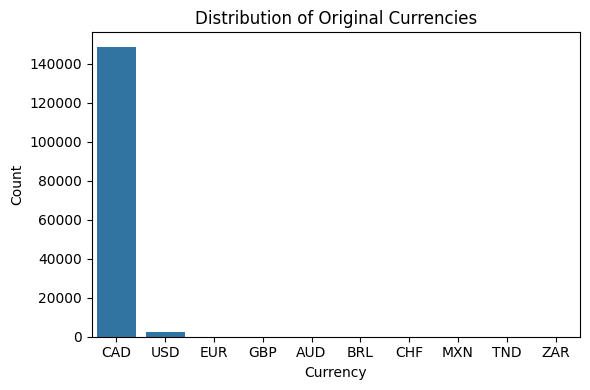

In [157]:
## Original Currency — Currency Distribution
plt.figure(figsize=(6,4))
currency_counts = final_df['original_currency'].value_counts()

sns.barplot(x=currency_counts.index, y=currency_counts.values)
plt.title("Distribution of Original Currencies")
plt.xlabel("Currency")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


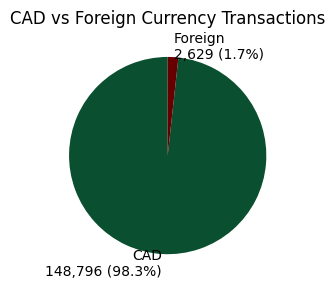

In [292]:

# Create CAD vs FOREIGN grouping
currency_simple = final_df['original_currency'].apply(
    lambda x: 'CAD' if x == 'CAD' else 'Foreign'
)

counts = currency_simple.value_counts()

plt.figure(figsize=(3,3))
plt.pie(
    counts.values,
    labels=[f"{label}\n{value:,} ({value / counts.sum():.1%})" for label, value in counts.items()],
    startangle=90,
    colors=['#0A4F2F', "#660000"],  # blue for CAD, red for foreign
    textprops={'fontsize': 10, 'color': 'black'}  # more legible labels
)

plt.title("CAD vs Foreign Currency Transactions", fontsize=12)
plt.tight_layout()
plt.show()



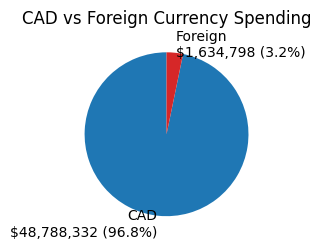

In [293]:
# Create CAD vs FOREIGN grouping
currency_simple = final_df['original_currency'].apply(
    lambda x: 'CAD' if x == 'CAD' else 'Foreign'
)

# Sum transaction amounts by CAD vs Foreign
amounts = final_df.groupby(currency_simple)['trx_amt'].sum()

plt.figure(figsize=(3,3))
plt.pie(
    amounts.values,
    labels=[f"{label}\n${value:,.0f} ({value / amounts.sum():.1%})" 
            for label, value in amounts.items()],
    startangle=90,
    colors=['#1F77B4', '#D62728'],  # blue = CAD, red = Foreign
    textprops={'fontsize': 10, 'color': 'black'}
)

plt.title("CAD vs Foreign Currency Spending", fontsize=12)
plt.tight_layout()
plt.show()


In [160]:
# Create CAD vs FOREIGN grouping
currency_simple = final_df['original_currency'].apply(
    lambda x: 'CAD' if x == 'CAD' else 'Foreign'
)

# Calculate mean and median for each group
stats = final_df.groupby(currency_simple)['trx_amt'].agg(['mean', 'median'])

stats


,mean,median
original_currency,,
CAD,327.887393,101.765
Foreign,621.832579,231.590


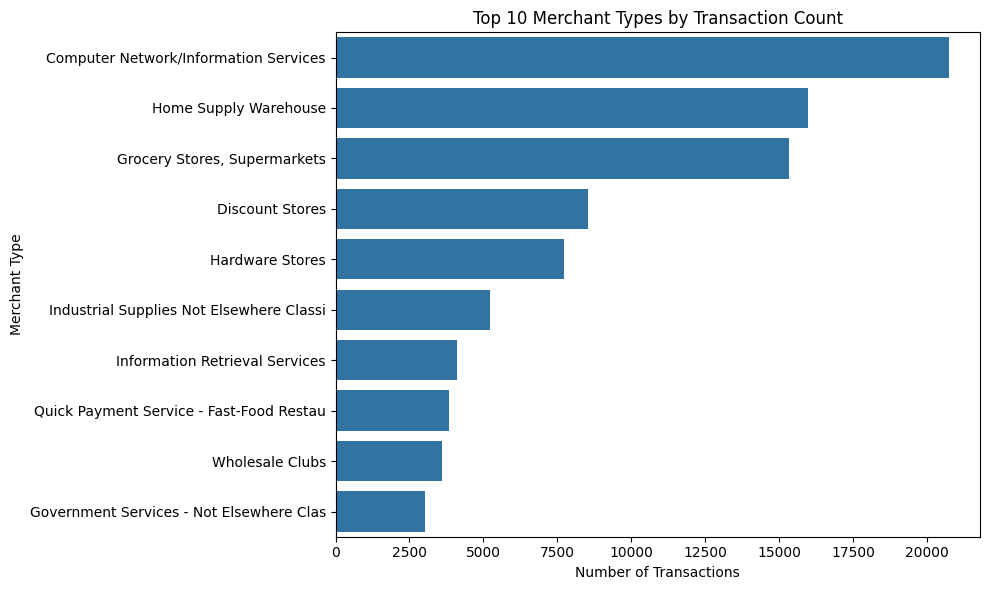

In [161]:
plt.figure(figsize=(10,6))
top_types = final_df['merchant_type_desc'].value_counts().head(10)

sns.barplot(x=top_types.values, y=top_types.index)
plt.title("Top 10 Merchant Types by Transaction Count")
plt.xlabel("Number of Transactions")
plt.ylabel("Merchant Type")
plt.tight_layout()
plt.show()


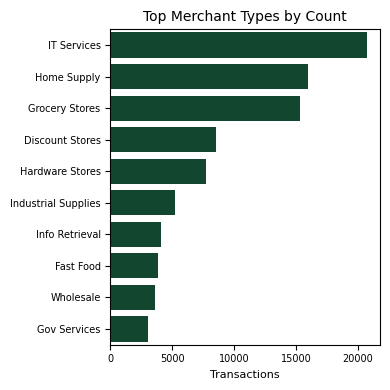

In [162]:
merchant_type_short = {
    "Computer Network/Information Services": "IT Services",
    "Home Supply Warehouse": "Home Supply",
    "Grocery Stores, Supermarkets": "Grocery Stores",
    "Discount Stores": "Discount Stores",
    "Hardware Stores": "Hardware Stores",
    "Industrial Supplies Not Elsewhere Classi": "Industrial Supplies",
    "Information Retrieval Services": "Info Retrieval",
    "Quick Payment Service - Fast-Food Restau": "Fast Food",
    "Wholesale Clubs": "Wholesale",
    "Government Services - Not Elsewhere Clas": "Gov Services"
}

top_types = final_df['merchant_type_desc'].value_counts().head(10)

# Map to short names
short_index = [merchant_type_short.get(t, t) for t in top_types.index]

plt.figure(figsize=(4,4))

sns.barplot(
    x=top_types.values,
    y=short_index,
    color="#0A4F2F"
)

plt.title("Top Merchant Types by Count", fontsize=10)
plt.xlabel("Transactions", fontsize=8)
plt.ylabel("", fontsize=8)

plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

plt.tight_layout()
plt.show()


I will focus the analysis in the Top 3 Division

In [163]:
top3_divisions = final_df['division'].value_counts().head(3).index.tolist()
print("Top 3 divisions:", top3_divisions)

# Create separate DataFrames
df_div1 = final_df[final_df['division'] == top3_divisions[0]].copy()
df_div2 = final_df[final_df['division'] == top3_divisions[1]].copy()
df_div3 = final_df[final_df['division'] == top3_divisions[2]].copy()

Top 3 divisions: ['PARKS, FORESTRY & RECREATION', 'TORONTO WATER', 'ECONOMIC DEVELOPMENT & CULTURE']


In [164]:
print("Descriptive statistics for ", top3_divisions[0])
print(df_div1['trx_amt'].describe())

print("Descriptive statistics for ", top3_divisions[1])
print(df_div2['trx_amt'].describe())

print("Descriptive statistics for ", top3_divisions[2])
print(df_div3['trx_amt'].describe())

Descriptive statistics for  PARKS, FORESTRY & RECREATION
count    65457.000000
mean       254.712449
std        477.390091
min      -5000.000000
25%         37.180000
50%         92.060000
75%        248.580000
max       9990.000000
Name: trx_amt, dtype: float64
Descriptive statistics for  TORONTO WATER
count    13590.000000
mean       390.974621
std        745.056084
min      -3780.920000
25%         51.832500
50%        145.000000
75%        387.277500
max       9807.960000
Name: trx_amt, dtype: float64
Descriptive statistics for  ECONOMIC DEVELOPMENT & CULTURE
count     8766.000000
mean       326.680922
std        705.461378
min      -2267.510000
25%         23.940000
50%         79.090000
75%        282.390000
max      13468.540000
Name: trx_amt, dtype: float64


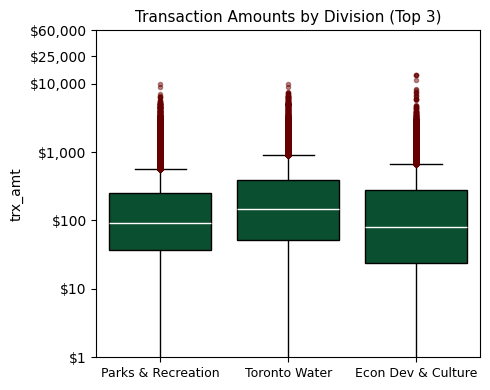

In [294]:
# Your mapping
short_names = {
    "PARKS, FORESTRY & RECREATION": "Parks & Recreation",
    "TORONTO WATER": "Toronto Water",
    "ECONOMIC DEVELOPMENT & CULTURE": "Econ Dev & Culture",
    "FACILITIES MANAGEMENT": "Facilities Mgmt",
    "LONG-TERM CARE HOMES & SERVICES": "Long-Term Care",
    "LEGAL SERVICES": "Legal Services",
    "SHELTER, SUPPORT & HOUSING ADMINSTRATION": "Shelter & Housing",
    "PUBLIC HEALTH": "Public Health",
    "SOLID WASTE MANAGEMENT": "Solid Waste",
    "TORONTO PARAMEDIC SERVICES": "Paramedic Services"
}

# Combine and map labels
df_compare = pd.concat([
    df_div1.assign(division=top3_divisions[0]),
    df_div2.assign(division=top3_divisions[1]),
    df_div3.assign(division=top3_divisions[2])
])

df_compare["division_short"] = df_compare["division"].map(short_names)

plt.figure(figsize=(5,4))

sns.boxplot(
    data=df_compare,
    x="division_short",
    y="trx_amt",
    boxprops=dict(facecolor="#0A4F2F", edgecolor="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    medianprops=dict(color="white"),
    flierprops=dict(
        marker='o',
        markersize=3,
        markerfacecolor="#660000",
        markeredgecolor="#660000",
        alpha=0.45
    )
)

plt.yscale('log')
plt.gca().yaxis.set_minor_locator(mtick.NullLocator())

plt.title("Transaction Amounts by Division (Top 3)", fontsize=11)

# Clean y-axis ticks
yticks = [1, 10, 100, 1000, 10000, 25000, 60000]
plt.yticks(yticks)
plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f'${int(x):,}')
)

plt.xlabel("")  # no axis label
plt.xticks(fontsize=9)  # readable & clean (short names are already short)

plt.tight_layout()
plt.show()


In [166]:
def analyze_division(df, division_name):
    print(f"{division_name}")

    # -Histogram + Boxplot -----
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(df['trx_amt'].dropna(), bins=40, color="skyblue", edgecolor="black")
    plt.xscale("log")
    plt.title(f"{division_name} — Transaction Amounts (log scale)")
    plt.xlabel("Transaction Amount")
    plt.ylabel("Count")

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df['trx_amt'], color="lightgreen")
    plt.yscale("log")
    plt.title(f"{division_name} — Boxplot of Transaction Amounts")
    plt.ylabel("Transaction Amount")

    plt.tight_layout()
    plt.show()

    # Top 20 merchants -----
    plt.figure(figsize=(10,6))
    top_merchants = df['merchant_name'].value_counts().head(20)
    sns.barplot(x=top_merchants.values, y=top_merchants.index)
    plt.title(f"{division_name} — Top 20 Merchants")
    plt.xlabel("Number of Transactions")
    plt.ylabel("Merchant")
    plt.tight_layout()
    plt.show()

    # Currency distribution -----
    plt.figure(figsize=(6,4))
    currency_counts = df['original_currency'].value_counts()
    sns.barplot(x=currency_counts.index, y=currency_counts.values)
    plt.title(f"{division_name} — Distribution of Original Currencies")
    plt.xlabel("Currency")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Top 10 merchant types -----
    plt.figure(figsize=(10,6))
    top_types = df['merchant_type_desc'].value_counts().head(10)
    sns.barplot(x=top_types.values, y=top_types.index)
    plt.title(f"{division_name} — Top 10 Merchant Types")
    plt.xlabel("Number of Transactions")
    plt.ylabel("Merchant Type")
    plt.tight_layout()
    plt.show()

PARKS, FORESTRY & RECREATION


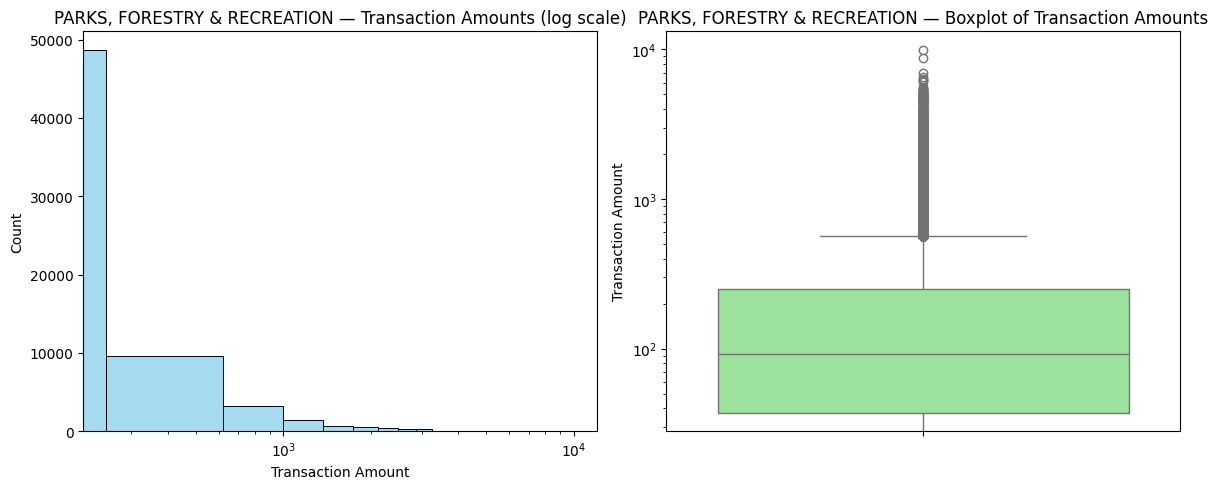

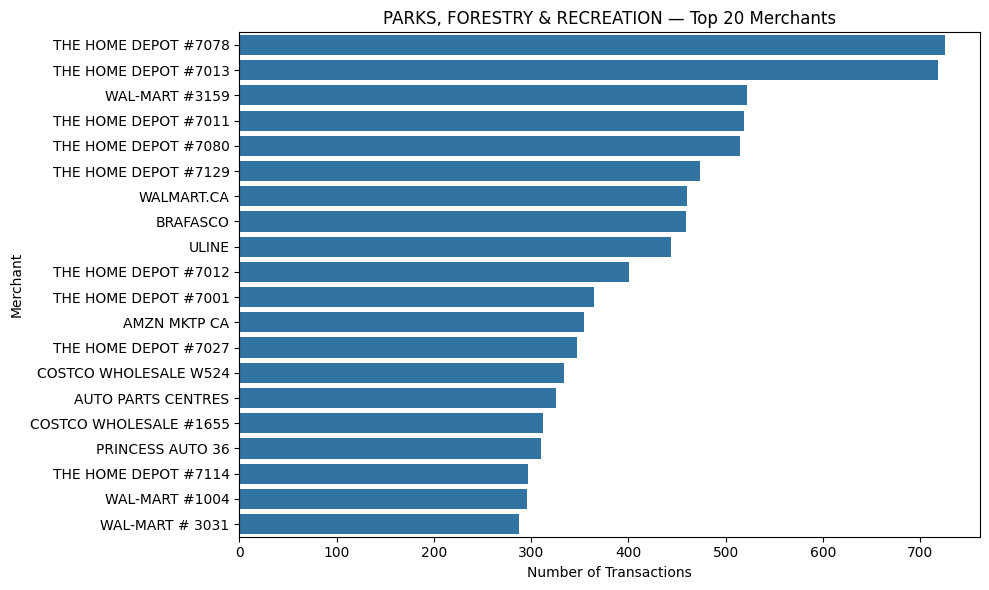

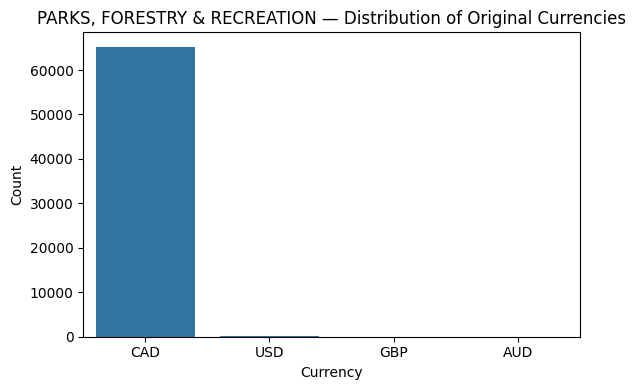

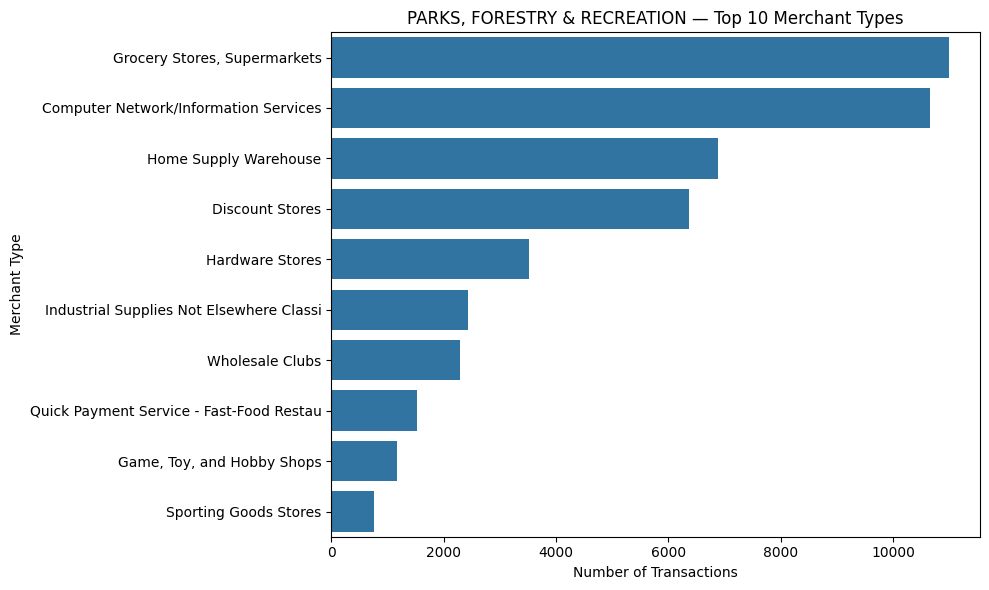

TORONTO WATER


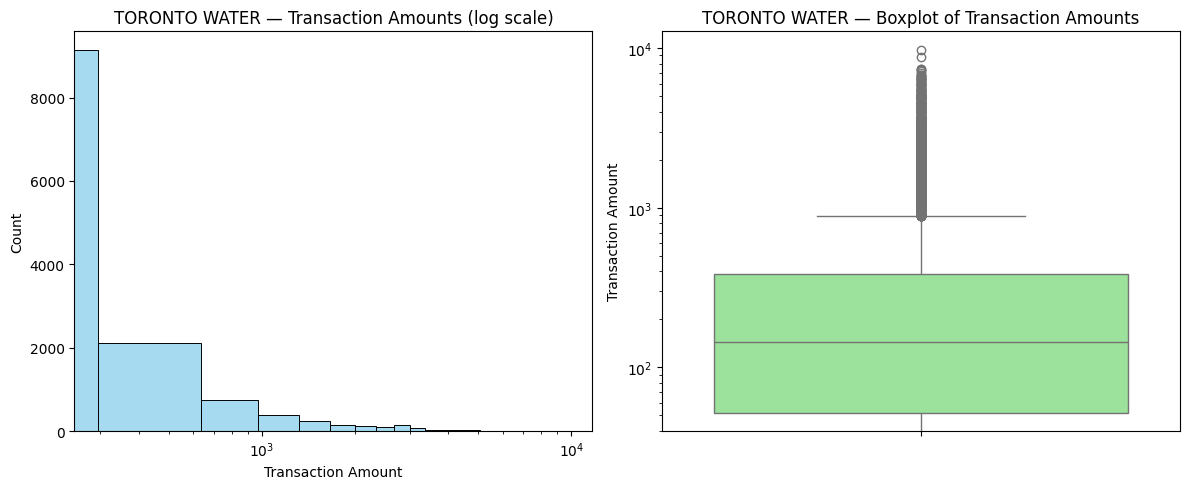

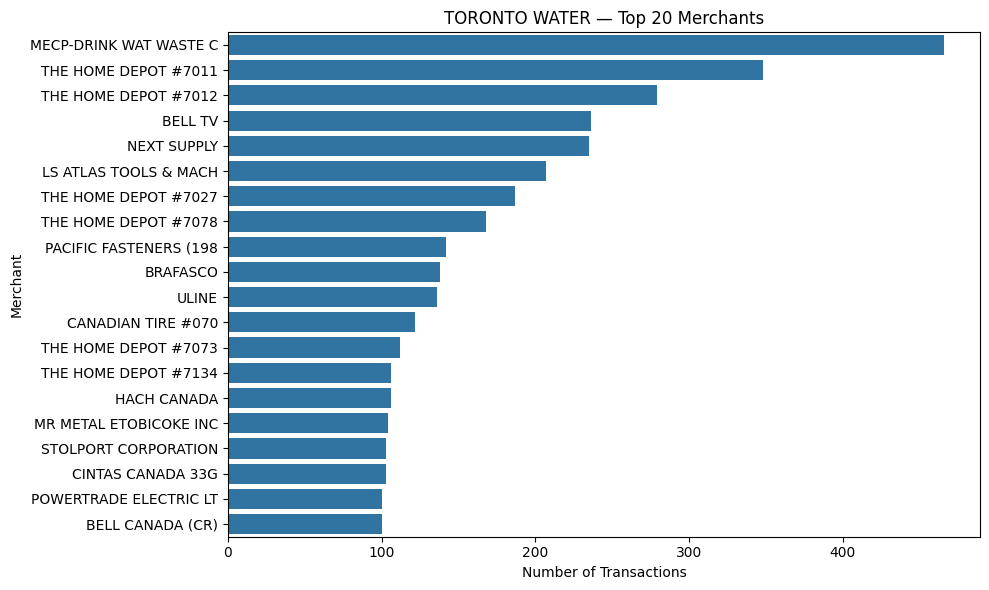

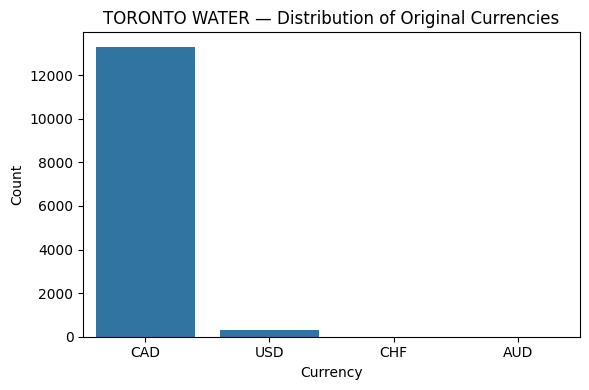

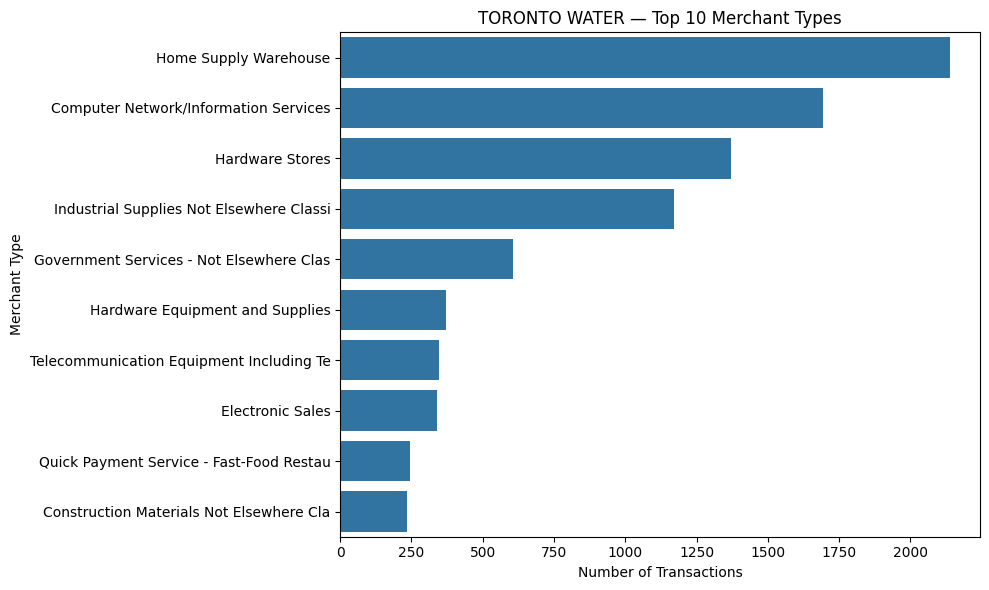

ECONOMIC DEVELOPMENT & CULTURE


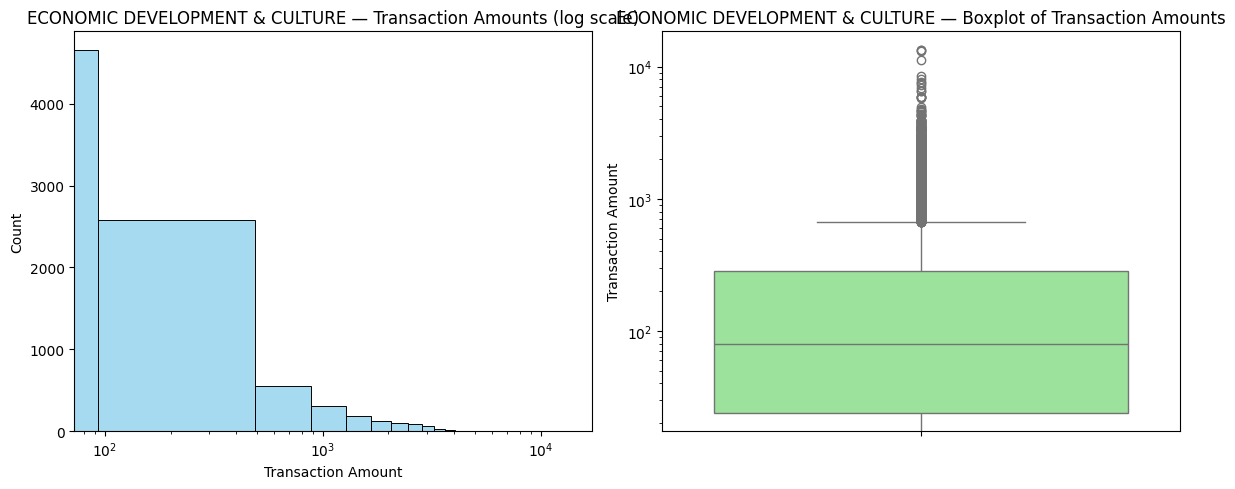

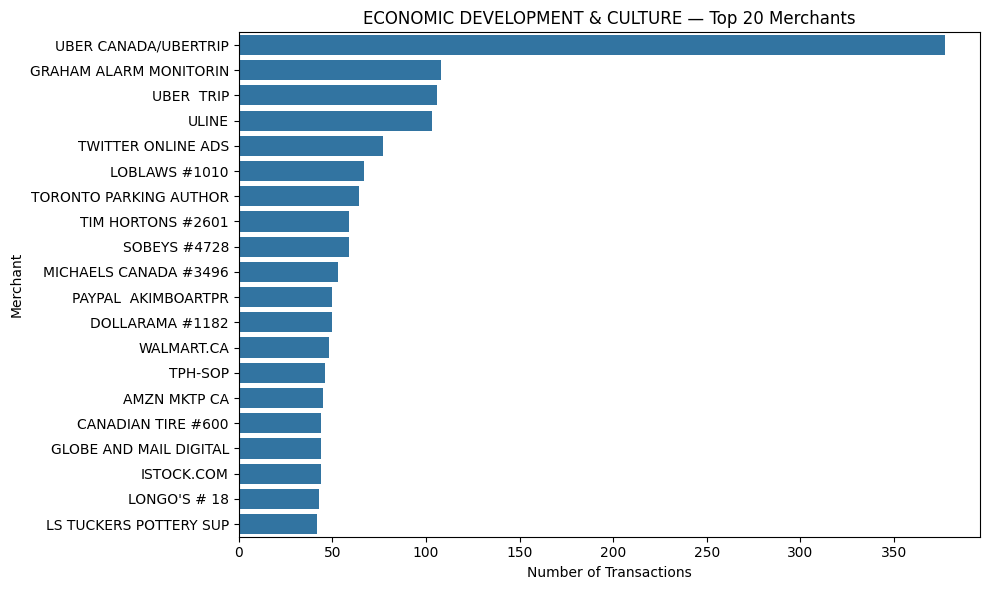

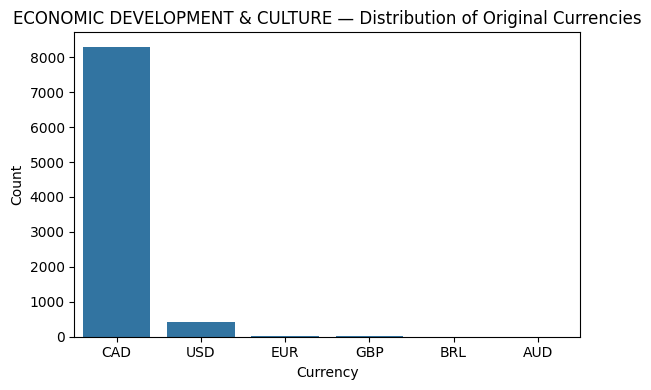

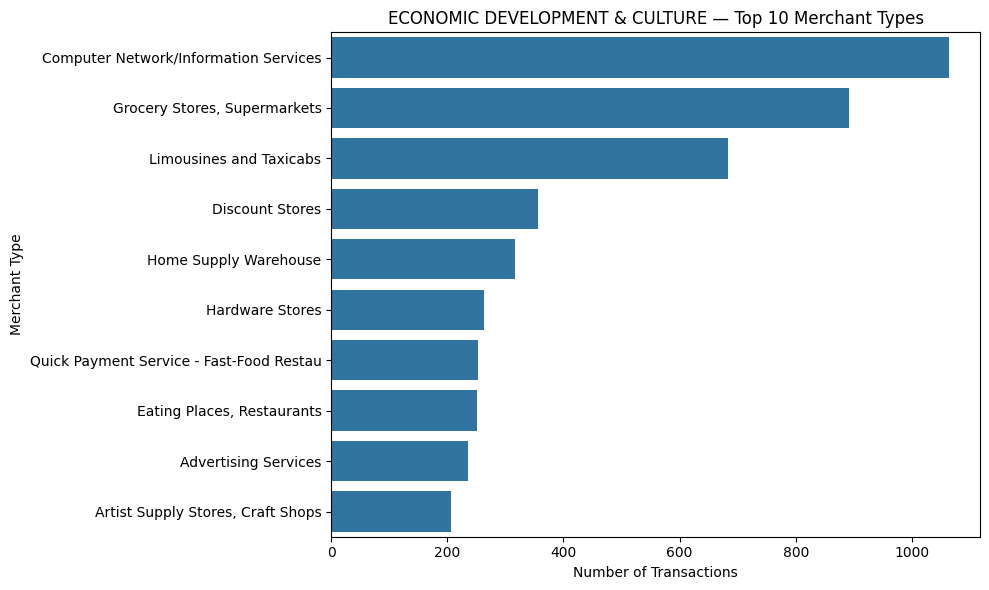

In [167]:
analyze_division(df_div1, top3_divisions[0])
analyze_division(df_div2, top3_divisions[1])
analyze_division(df_div3, top3_divisions[2])

### Research Questions

For the research questions, I am going to focus the analysis into potential fraud that might occur within public spending. For this, I have to make some assumptions:
- The purpose of the P-card is small non recurrent purchases ($300 CAD)
- Spending shoud be limited to working hours, normally Monday-Friday from 7 to 6pm
- Spending should be done locally, meaning it should be done in CAD
- The card spending should go up to 5000 per transaction, everything above I assume it should follow a standard purchasing process
- Merchants should match expected vendor categories, unsual vendors for a division may indicate misuse.
- Transactions should not be split to bypass controls, multiple same-day transactions to the same merchant within minutes may represent “split purchases” to avoid approval thresholds.
- Refunds should be infrequent and justified

Based on the data available in the dataset and ease of analysis I will first work with these research questions:

1. Is the average P-Card transaction amount equal to $300 (small purchase)?
2. Is the average weekend spending the same as the weekday spending?
2. 2A - Is the average weekend spending higher than the weekday spending?
3. Does the Economic Development & Culture division have a significantly higher proportion of foreign-currency transactions than all other divisions?



#### 1. 1. Is the average P-Card transaction amount equal to $300 (small purchase)?


- **Null Hypothesis (H₀)**: The true mean P-Card transaction amount is $300.
- **Alternative Hypothesis (H₁)**: tThe true mean is different from $300.

This is a one-sample test

In [168]:
from scipy.stats import ttest_1samp

# sample of transaction amounts
amounts = final_df['trx_amt']

# hypothesized mean (benchmark for small purchase)
mu_0 = 300  

t_stat, p_value = ttest_1samp(amounts, popmean=mu_0)

t_stat, p_value

(np.float64(15.29706633924594), np.float64(8.760814275551021e-53))

Interpretation

The average transaction amount was $332.99, which is moderately higher than the $300 benchmark used to represent a typical small purchase. The one-sample t-test shows this difference is statistically significant (t = 15.30, p < 0.001), meaning it is extremely unlikely to be due to chance. Because the p-value is far below 0.05, I reject the null hypothesis and conclude that P-Cards are being used for purchases that are larger than what would normally be expected for routine, low-value spending.

In [169]:
final_df['trx_amt'].mean()

np.float64(332.99078969787024)

#### 2. Is the average weekend spending the same as the weekday spending?

- **Null Hypothesis (H₀)**: weekend spending is the same as weekday spending.
- **Alternative Hypothesis (H₁)**: weekend spending is different (higher or lower)

I am comparing the mean transaction amounts between two independent groups. It is a two sample t-test.

In [170]:
## Getting weekday and weekend
final_df['weekday'] = final_df['trx_dt'].dt.weekday 
## Creating a flag as is_weekend column
final_df['is_weekend'] = final_df['weekday'] >= 5

In [171]:
# Select the transaction amounts for transactions that occurred on weekends
weekend_trx = final_df[final_df['is_weekend']]['trx_amt']
# Select the transaction amounts for transactions that did NOT occur on weekends
weekday_trx = final_df[~final_df['is_weekend']]['trx_amt']

In [173]:
t_stat, p_value = ttest_ind(weekend_trx, weekday_trx, equal_var=False)

t_stat, p_value

(np.float64(-18.836759078260847), np.float64(2.9365909377466043e-78))

Interpreation 

The p-value is far below the 0.05 significance level, which means that thisd ifference is not due to chance.

Weekend transaction amounts are significantly higher than weekday amounts

I reject the null hypothesis. I have strong statistical evidence that weekend spending differs from weekday spending. This doesn't that those transactions are fraud though, but we have to investigate further to see if there is a reasonable explanation that we can find.

#### 2a.Is the average weekend spending higher than the weekday spending?

- **Null Hypothesis (H₀)**: The average weekend spending is not higher than the average weekday spending.
- **Alternative Hypothesis (H₁)**: The average weekend spending is higher than the average weekday spending.


I am comparing the mean transaction amounts between two independent groups, so this is a one-tailed two-sample t-test (Welch’s t-test).

In [296]:
# Run two-tailed Welch t-test
t_stat, p_value_two_tailed = stats.ttest_ind(
    weekend_trx,
    weekday_trx,
    equal_var=False,
    nan_policy='omit'
)

# Convert two-tailed p-value to one-tailed (weekend > weekday)
p_value_one_tailed = p_value_two_tailed / 2

print("T-statistic:", t_stat)
print("One-tailed p-value (weekend > weekday):", p_value_one_tailed)


T-statistic: -18.836759078260847
One-tailed p-value (weekend > weekday): 1.4682954688733022e-78


A one-tailed Welch’s t-test found no evidence that weekend spending is higher than weekday spending (t = –18.84, p < 0.001). In fact, the negative t-statistic indicates that weekday transactions are significantly larger on average.

In [175]:
# Compare means for context
print("\nWeekend mean:", weekend_trx.mean())
print("Weekday mean:", weekday_trx.mean())

# Mean & median for weekday

print("\nWeekend median:", weekend_trx.median())
print("Weekday median:", weekday_trx.median())


Weekend mean: 212.90628786003137
Weekday mean: 343.43573118557435

Weekend median: 71.18
Weekday median: 107.97


In [176]:
n_weekend = weekend_trx.count()
n_weekday = weekday_trx.count()
total = len(final_df)

pct_weekend = n_weekend / total * 100
pct_weekday = n_weekday / total * 100

n_weekend, pct_weekend

print(f"There were {n_weekend:,} transactions on weekends, representing {pct_weekend:.2f}% of all transactions.")



There were 12,117 transactions on weekends, representing 8.00% of all transactions.


#### 3. Does the Economic Development & Culture division have a significantly higher proportion of foreign-currency transactions than all other divisions?

p₁ = proportion of foreign-currency transactions in EDC

p₂ = proportion in all other divisions

**Null Hypothesis (H₀):** The proportion of foreign-currency transactions in the Economic Development & Culture division is the **same** as the proportion in all other divisions.

**Alternative Hypothesis (H₁):** The proportion of foreign-currency transactions in the Economic Development & Culture division is **higher** than the proportion in all other divisions.

Amongst all divisions, this is the one that most logically could engage in international-facing activities such as global business development, trade missions, tourism initiatives, and cultural exchanges, making foreign vendors and international transactions a natural part of its operations.
One-tailed two-proportion z-test

In [178]:
# foreign currency flag
final_df['is_foreign'] = final_df['original_currency'] != "CAD"

# groups
edc = final_df[final_df['division'] == "ECONOMIC DEVELOPMENT & CULTURE"]
others = final_df[final_df['division'] != "ECONOMIC DEVELOPMENT & CULTURE"]

In [179]:
# Create a summary table: division, count of transactions, and total transaction amount
division_summary = (
    final_df.groupby('division')
    .agg(
        transaction_count = ('trx_amt', 'count'),
        total_amount = ('trx_amt', 'sum'),
        foreign_transaction_count = ('is_foreign', 'sum' )
    )
    .sort_values(by='transaction_count', ascending=False)
)

# Display the top 15 divisions
division_summary

,transaction_count,total_amount,foreign_transaction_count
division,,,
"PARKS, FORESTRY & RECREATION",65457,16672712.77,234
TORONTO WATER,13590,5313345.10,292
ECONOMIC DEVELOPMENT & CULTURE,8766,2863684.96,467
FACILITIES MANAGEMENT,8632,2431364.46,44
LONG-TERM CARE HOMES & SERVICES,6751,1713433.08,63
...,...,...,...
"EQUITY, DIVERSITY AND HUMAN RIGHTS OFFICE",7,9531.30,0
DEVELOPMENT & GROWTH SERVICES,6,2528.25,1
OFFICE OF CHIEF INFORMATION SECURITY,5,282.40,0


In [180]:
# proportions
p1 = edc['is_foreign'].mean()
p2 = others['is_foreign'].mean()

# sample sizes
n1 = len(edc)
n2 = len(others)

# pooled proportion
p_pool = (edc['is_foreign'].sum() + others['is_foreign'].sum()) / (n1 + n2)

# standard error
se = sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))

# z-statistic
z = (p1 - p2) / se

# one-tailed p-value
p_value = 1 - norm.cdf(z)

z, p_value

(np.float64(26.52159339070176), np.float64(0.0))

Interpretation
The results show a very large positive z-statistic (z = 26.52) with a p-value off 0. We reject H₀ and conclude that EDC has a significantly higher proportion of foreign-currency transactions compared to all other divisions. 
This aligns with its international purpose (trade missions, global partnerships, tourism promotion), but also highlights areas where additional monitoring of foreign purchases may be appropriate.

### Data cleaning and exploration - Second part


Continuing with the comparison of weekend spending vs weekday spending, after knowing there is a statistical difference, then I find out which one is higher.

In [181]:
# Mean and median comparison
weekday_mean = weekday_trx.mean()
weekend_mean = weekend_trx.mean()

weekday_median = weekday_trx.median()
weekend_median = weekend_trx.median()

print(f"Average (mean) weekday transaction amount: ${weekday_mean:,.2f}")
print(f"Average (mean) weekend transaction amount: ${weekend_mean:,.2f}")

print(f"Median weekday transaction amount: ${weekday_median:,.2f}")
print(f"Median weekend transaction amount: ${weekend_median:,.2f}")



Average (mean) weekday transaction amount: $343.44
Average (mean) weekend transaction amount: $212.91
Median weekday transaction amount: $107.97
Median weekend transaction amount: $71.18


I want to use the merchants for further analysis, but there is too many of them, I will try to reduce the number by normalizing the names (removing extra spaces, converting to uppercase, etc.) and then grouping similar names together based on common keywords or patterns.
This way, I can consolidate merchants that are essentially the same but have slight variations in their names.

In [182]:
total_merchants = final_df['merchant_name'].count()
unique_merchants = final_df['merchant_name'].nunique()
print("Total unique merchants:", unique_merchants, "from a total of", total_merchants)

Total unique merchants: 33219 from a total of 151425


In [297]:

def clean_merchant(name):
    name = name.upper()
    name = re.sub(r"\d+", "", name)        # remove numbers
    name = re.sub(r"[^A-Z ]", "", name)    # remove non-letters
    name = re.sub(r"\bTHE\b", "", name)           # remove standalone THE
    name = re.sub(r"\s+", " ", name)       # collapse spaces
    return name.strip()

final_df["merchant_clean"] = final_df["merchant_name"].apply(clean_merchant)

In [184]:
unique_merchants_clean = final_df['merchant_clean'].nunique()
print("Total unique merchants:", unique_merchants, ". Total unique merchants cleaned:", unique_merchants_clean,"reduction of:", unique_merchants - unique_merchants_clean)
print("Change of:", unique_merchants_clean/unique_merchants-1)

Total unique merchants: 33219 . Total unique merchants cleaned: 28743 reduction of: 4476
Change of: -0.13474216562810437


In [185]:
final_df["brand_prefix2"] = final_df["merchant_clean"].apply(lambda x: " ".join(x.split()[:2]))
unique_merchants_clean_2word = final_df['brand_prefix2'].nunique()

print("Total clean unique merchants:", unique_merchants_clean, "After 2 word extraction", unique_merchants_clean_2word,"reduction of:", unique_merchants_clean - unique_merchants_clean_2word)
print("Change of:", unique_merchants_clean_2word/unique_merchants_clean-1)

Total clean unique merchants: 28743 After 2 word extraction 12467 reduction of: 16276
Change of: -0.5662596110357304


Fuzzy matching didn't add any value after 2 word extraction approach.
The use of LLM models failed or got to complex, so I will go with this normalization. It is not optimum but is good enough if we think it from a cost benefit perspective

In [186]:
final_df["final_merchant"]=final_df["brand_prefix2"]

In [187]:
top20_by_count = (
    final_df.groupby("final_merchant")
            .size()
            .reset_index(name="transaction_count")
            .sort_values(by="transaction_count", ascending=False)
            .head(20)
)

top20_by_count


,final_merchant,transaction_count
3714,AMZN MKTP,16928
6896,HOME DEPOT,13359
5246,DOLLARAMA,6239
12046,WALMART,3872
8643,ONLANDS,3804
4483,CANADIAN TIRE,3126
4930,COSTCO WHOLESALE,3107
4612,CDN TIRE,2118
8136,METRO,1900
11488,TIM HORTONS,1711


In [188]:
top_divisions = [
    "PARKS, FORESTRY & RECREATION",
    "TORONTO WATER",
    "ECONOMIC DEVELOPMENT & CULTURE"
]

top20_by_count_divisions = {}

for div in top_divisions:
    df_div = final_df[final_df["division"] == div]
    
    top20 = (
        df_div.groupby("final_merchant")
              .size()
              .reset_index(name="transaction_count")
              .sort_values(by="transaction_count", ascending=False)
              .head(10)
    )
    
    top20_by_count_divisions[div] = top20

top20_by_count_divisions



{'PARKS, FORESTRY & RECREATION':         final_merchant  transaction_count
 1826         AMZN MKTP               8819
 3059        HOME DEPOT               5350
 2416         DOLLARAMA               4617
 4920           WALMART               3114
 2300  COSTCO WHOLESALE               1968
 2136     CANADIAN TIRE               1553
 3539             METRO               1300
 2178          CDN TIRE               1261
 3548          MICHAELS                874
 2873       FOOD BASICS                793,
 'TORONTO WATER':         final_merchant  transaction_count
 750         HOME DEPOT               1817
 350          AMZN MKTP               1357
 933      MECPDRINK WAT                466
 475      CANADIAN TIRE                436
 490           CDN TIRE                291
 409            BELL TV                236
 1008       NEXT SUPPLY                235
 1128     PRINCESS AUTO                219
 897           LS ATLAS                210
 540   COSTCO WHOLESALE                185,
 'E

In [189]:
top20_by_amount = (
    final_df.groupby("final_merchant")["trx_amt"]
            .sum()
            .reset_index(name="total_amount")
            .sort_values(by="total_amount", ascending=False)
            .head(20)
)

top20_by_amount


,final_merchant,total_amount
6896,HOME DEPOT,2738593.03
8338,MTO TSD,2691678.31
3714,AMZN MKTP,1756323.87
11814,ULINE,1172750.65
4930,COSTCO WHOLESALE,596316.89
4483,CANADIAN TIRE,457922.76
12046,WALMART,427163.39
3920,AVENUE MOTEL,417270.77
8336,MTO RUS,369168.14
5246,DOLLARAMA,331628.97


In [190]:
high_value_df = final_df[final_df["trx_amt"] >= 5000]


In [191]:
top20_high_by_count = (
    high_value_df.groupby("final_merchant")
                 .size()
                 .reset_index(name="transaction_count")
                 .sort_values(by="transaction_count", ascending=False)
                 .head(20)
)

top20_high_by_count


,final_merchant,transaction_count
119,MTO TSD,239
117,MTO RUS,29
118,MTO RUSSO,23
67,FUNDSCRIP,13
137,PRESCRIPTION CARE,12
138,PRESTO BLUM,9
193,WATERLOO MANUFACTURING,8
113,MITCHELLSNAPON CAN,8
141,RADCOMM SYSTEMS,7
149,SHOPPERS DRUG,7


In [192]:
top20_high_by_amount = (
    high_value_df.groupby("final_merchant")["trx_amt"]
                 .sum()
                 .reset_index(name="total_amount")
                 .sort_values(by="total_amount", ascending=False)
                 .head(20)
)

top20_high_by_amount


,final_merchant,total_amount
119,MTO TSD,2357567.80
117,MTO RUS,263045.75
118,MTO RUSSO,227443.00
67,FUNDSCRIP,167859.87
138,PRESTO BLUM,148785.00
173,TERANET INC,105530.70
73,GIVEX MCDONALD,72551.70
137,PRESCRIPTION CARE,68815.86
155,SOFTCHOICE LP,59598.91
111,METRO HEAD,52800.00


Exclude MTO merchants

### Outliers study


Outliers are a central component of fraud analysis because fraudulent transactions rarely follow normal spending patterns. Instead, they tend to appear as unusual spikes in amount, frequency, merchant type, timing, or user behavior. By focusing on transactions that fall far outside typical ranges, analysts can quickly identify potential anomalies that warrant deeper investigation. Not every outlier is fraud, but almost every fraud case starts as an outlier—making outlier detection a critical first step in uncovering irregular or suspicious activity.

In [193]:
# 1. Compute mean and std
mean_val = final_df["trx_amt"].mean()
std_val = final_df["trx_amt"].std()

# 2. Compute z-score
final_df["z_score"] = (final_df["trx_amt"] - mean_val) / std_val

# 3. Define thresholds
z_threshold = 3        # strong statistical outlier
business_threshold = 5000  # policy rule

# 4. Create 'outlier' column
def classify_outlier(row):
    amt = row["trx_amt"]
    z = row["z_score"]

    if amt >= business_threshold:
        return "business_outlier"       # highest priority
    elif z > z_threshold:
        return "zscore_outlier"
    else:
        return "no"

final_df["outlier"] = final_df.apply(classify_outlier, axis=1)


In [194]:
counts = final_df["outlier"].value_counts()
counts

outlier
no                  149185
zscore_outlier        1602
business_outlier       638
Name: count, dtype: int64

In [195]:
sum_by_outlier = final_df.groupby("outlier")["trx_amt"].sum()
sum_by_outlier


outlier
business_outlier     5585852.54
no                  39290434.94
zscore_outlier       5546842.85
Name: trx_amt, dtype: float64

In [196]:
sumtotal = final_df["trx_amt"].sum()
sumtotal

np.float64(50423130.33)

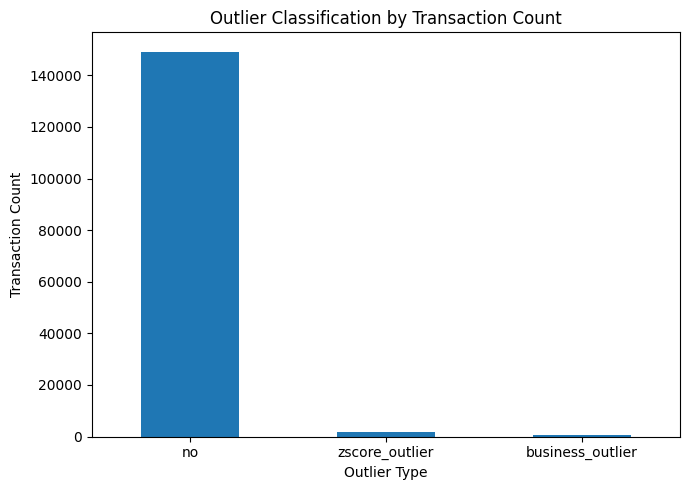

In [197]:
plt.figure(figsize=(7,5))
counts.plot(kind="bar")
plt.title("Outlier Classification by Transaction Count")
plt.xlabel("Outlier Type")
plt.ylabel("Transaction Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

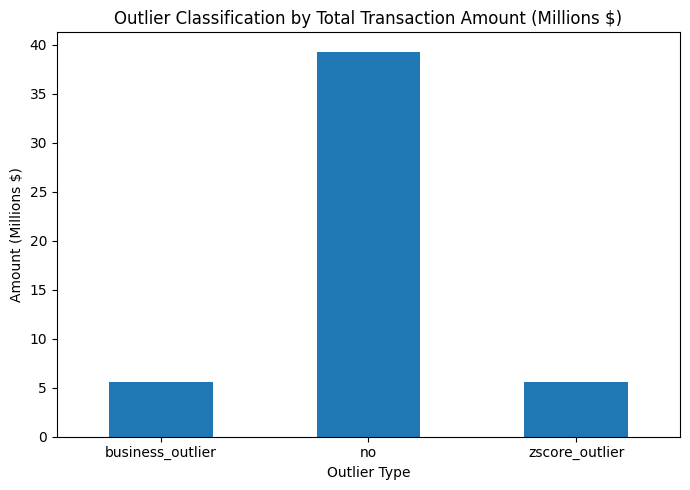

In [198]:
# Aggregate total amount by outlier type
amounts = final_df.groupby("outlier")["trx_amt"].sum()

amounts_m = amounts / 1_000_000

plt.figure(figsize=(7,5))
amounts_m.plot(kind="bar")

plt.title("Outlier Classification by Total Transaction Amount (Millions $)")
plt.xlabel("Outlier Type")
plt.ylabel("Amount (Millions $)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



In [199]:
# ===============================================================
# 1. OVERALL OUTLIERS (anything that is NOT "no")
# ===============================================================

outlier_mask = final_df["outlier"] != "no"

overall_outlier_count = outlier_mask.sum()
total_count = len(final_df)
overall_pct_count = (overall_outlier_count / total_count) * 100

overall_outlier_amount = final_df.loc[outlier_mask, "trx_amt"].sum()
total_amount = final_df["trx_amt"].sum()
overall_pct_amount = (overall_outlier_amount / total_amount) * 100


# ===============================================================
# 2. BUSINESS OUTLIERS ONLY
# ===============================================================

biz_mask = final_df["outlier"] == "business_outlier"

biz_outlier_count = biz_mask.sum()
biz_pct_count = (biz_outlier_count / total_count) * 100

biz_outlier_amount = final_df.loc[biz_mask, "trx_amt"].sum()
biz_pct_amount = (biz_outlier_amount / total_amount) * 100


# ===============================================================
# 3. PRINT RESULTS
# ===============================================================

print("=== OUTLIER IMPACT SUMMARY ===")

print("\n--- Overall Outliers (z-score + business logic) ---")
print(f"Outlier transactions: {overall_outlier_count:,} out of {total_count:,} "
      f"({overall_pct_count:.2f}% of all transactions)")
print(f"Outlier total amount: ${overall_outlier_amount:,.2f} out of ${total_amount:,.2f} "
      f"({overall_pct_amount:.2f}% of total amount)")

print("\n--- Business Outliers Only ---")
print(f"Business outlier transactions: {biz_outlier_count:,} out of {total_count:,} "
      f"({biz_pct_count:.2f}% of all transactions)")
print(f"Business outlier total amount: ${biz_outlier_amount:,.2f} out of ${total_amount:,.2f} "
      f"({biz_pct_amount:.2f}% of total amount)")


=== OUTLIER IMPACT SUMMARY ===

--- Overall Outliers (z-score + business logic) ---
Outlier transactions: 2,240 out of 151,425 (1.48% of all transactions)
Outlier total amount: $11,132,695.39 out of $50,423,130.33 (22.08% of total amount)

--- Business Outliers Only ---
Business outlier transactions: 638 out of 151,425 (0.42% of all transactions)
Business outlier total amount: $5,585,852.54 out of $50,423,130.33 (11.08% of total amount)


In [200]:
final_df.columns

Index(['division', 'trx_id', 'trx_dt', 'merchant_name', 'trx_amt',
       'trx_currency', 'original_amt', 'original_currency', 'gl_account_desc',
       'merchant_type', 'merchant_type_desc', 'purpose', 'source_file',
       'year_month', 'month_num', 'month_name', 'weekday', 'is_weekend',
       'is_foreign', 'merchant_clean', 'brand_prefix2', 'final_merchant',
       'z_score', 'outlier'],
      dtype='object')


=== OUTLIERS BY DAY OF WEEK ===
              Outlier Count  Outlier % of All Txns  Outlier Amount  \
weekday_name                                                         
Monday                  334                   0.22      1564955.02   
Tuesday                 472                   0.31      2242324.60   
Wednesday               486                   0.32      2413179.19   
Thursday                439                   0.29      2291635.31   
Friday                  426                   0.28      2152523.16   
Saturday                 70                   0.05       394646.18   
Sunday                   13                   0.01        73431.93   

              Outlier % of Total Amount  
weekday_name                             
Monday                             3.10  
Tuesday                            4.45  
Wednesday                          4.79  
Thursday                           4.54  
Friday                             4.27  
Saturday                           0.78  


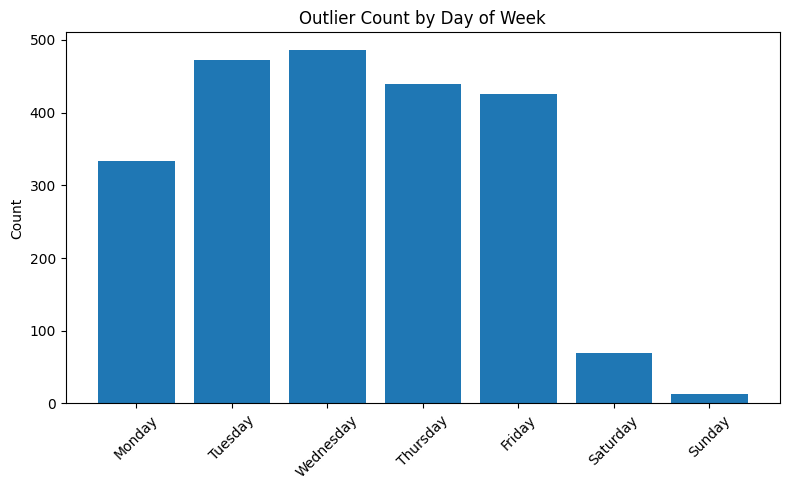

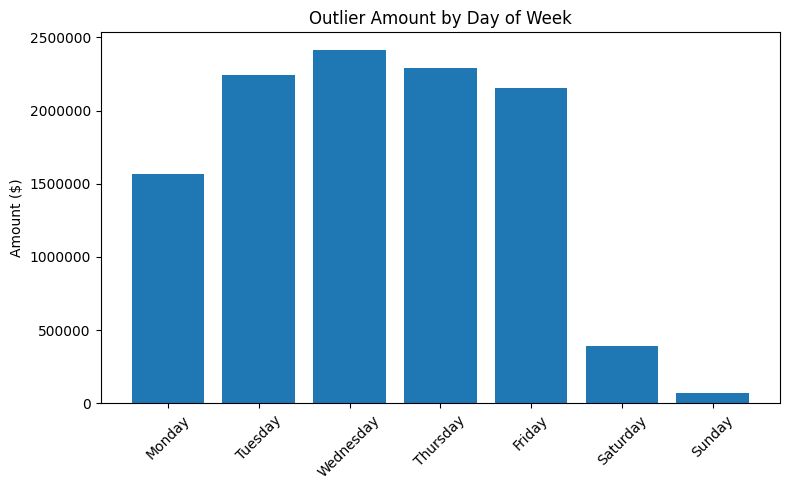

In [201]:
# Keep only outliers (anything not "no")
outlier_df = final_df[final_df["outlier"] != "no"].copy()

# Map weekday numbers → names for readability
weekday_map = {
    0: "Monday", 1: "Tuesday", 2: "Wednesday",
    3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"
}

final_df["weekday_name"] = final_df["weekday"].map(weekday_map)
outlier_df["weekday_name"] = outlier_df["weekday"].map(weekday_map)


# ---------------------------------------------------
# 1. OUTLIER COUNTS AND AMOUNTS BY WEEKDAY
# ---------------------------------------------------

dow_counts = outlier_df.groupby("weekday_name")["trx_amt"].count().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)

dow_amounts = outlier_df.groupby("weekday_name")["trx_amt"].sum().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)


# ---------------------------------------------------
# 2. PERCENTAGES
# ---------------------------------------------------

total_count = len(final_df)
total_amount = final_df["trx_amt"].sum()

dow_pct_count = (dow_counts / total_count) * 100
dow_pct_amount = (dow_amounts / total_amount) * 100


# ---------------------------------------------------
# 3. SUMMARY TABLE
# ---------------------------------------------------

summary = pd.DataFrame({
    "Outlier Count": dow_counts,
    "Outlier % of All Txns": dow_pct_count.round(2),
    "Outlier Amount": dow_amounts,
    "Outlier % of Total Amount": dow_pct_amount.round(2),
})

print("\n=== OUTLIERS BY DAY OF WEEK ===")
print(summary)


# ---------------------------------------------------
# 4. PLOTS
# ---------------------------------------------------

# Count plot
plt.figure(figsize=(8,5))
plt.bar(summary.index, summary["Outlier Count"])
plt.title("Outlier Count by Day of Week")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Amount plot
plt.figure(figsize=(8,5))
plt.bar(summary.index, summary["Outlier Amount"])
plt.title("Outlier Amount by Day of Week")
plt.xticks(rotation=45)
plt.ylabel("Amount ($)")
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()


Outliers are happening during normal business days, not weekends. Saturday & Sunday almost irrelevant, only 83 outliers combined and very little monetary contribution (0.9% of total outlier spend)

### Correlation analysis to focus the outliers/fraud analysis

Even though my dataset contains many variables, true correlation analysis is only meaningful when at least one variable is continuous, which in this case is trx_amt. This allows me to compute valid correlations only with binary or numeric variables such as is_weekend_flag, foreign_flag, is_outlier_flag, and month (converted to 1–12). These relationships make sense because binary variables allow a point-biserial correlation, and the month variable is ordinal numeric, making it appropriate for measuring seasonal or fiscal spending patterns. In contrast, variables like division (81 categories), merchant_type_desc (295 categories), purpose, or merchant_name (over 90k unique values) are high-cardinality categorical variables, meaning correlation is not appropriate and ANOVA becomes statistically trivial and practically meaningless due to the huge number of groups. For these variables, grouped summaries and top-N analysis are far more informative. Therefore, correlation analysis is limited to numeric and low-cardinality variables, while high-cardinality categorical variables require alternative exploratory techniques.

#### Is there a correlation between trx_amount and weekdays vs weekends?

In [202]:
final_df["is_weekend_flag"] = final_df["is_weekend"].astype(int)


In [203]:
corr_amt_weekend = final_df[["trx_amt", "is_weekend_flag"]].corr()
print(corr_amt_weekend)

                 trx_amt  is_weekend_flag
trx_amt           1.0000          -0.0422
is_weekend_flag  -0.0422           1.0000


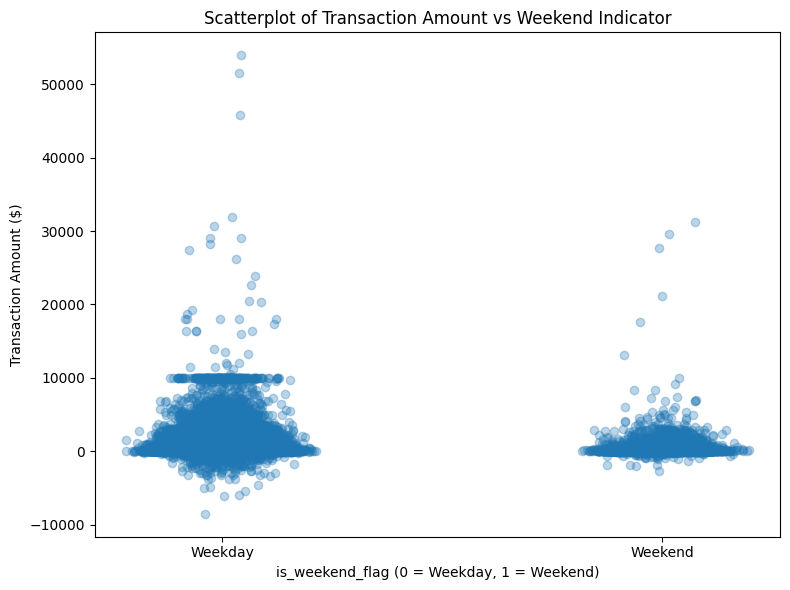

In [204]:
# Create jitter for visualization
jitter = np.random.normal(0, 0.05, size=len(final_df))

plt.figure(figsize=(8,6))
plt.scatter(
    final_df["is_weekend_flag"] + jitter, 
    final_df["trx_amt"], 
    alpha=0.3
)

plt.title("Scatterplot of Transaction Amount vs Weekend Indicator")
plt.xlabel("is_weekend_flag (0 = Weekday, 1 = Weekend)")
plt.ylabel("Transaction Amount ($)")
plt.xticks([0,1], ["Weekday", "Weekend"])
plt.tight_layout()
plt.show()

The correlation between trx_amt and is_weekend_flag is –0.0422, which is extremely close to zero. This indicates that there is no meaningful linear relationship between transaction amount and whether the transaction occurred on a weekday or weekend.

Both groups show a wide spread of transaction amounts

A regression here is meaningless because a single weekend flag cannot explain or predict transaction behavior in any meaningful way.

In [205]:
final_df.head(5)

,division,trx_id,trx_dt,merchant_name,trx_amt,trx_currency,original_amt,original_currency,gl_account_desc,merchant_type,...,weekday,is_weekend,is_foreign,merchant_clean,brand_prefix2,final_merchant,z_score,outlier,weekday_name,is_weekend_flag
0,TORONTO PARAMEDIC SERVICES,6338-1,2023-04-27,C/O OXFORD TRUCK STOP,100.00,CAD,100.00,CAD,GASOLINE,5542.0,...,3,False,False,CO OXFORD TRUCK STOP,CO OXFORD,CO OXFORD,-0.277623,no,Thursday,0
2,SOLID WASTE MANAGEMENT,6344-1,2023-05-05,LONDON ESSO FUEL CENTR,120.00,CAD,120.00,CAD,GASOLINE,5541.0,...,4,False,False,LONDON ESSO FUEL CENTR,LONDON ESSO,LONDON ESSO,-0.253792,no,Friday,0
4,FIRE SERVICES,6357-1,2023-05-23,SAYAL ELECTRONICS (TOR,25.88,CAD,25.88,CAD,ELECTRICAL SUPPLIES,5732.0,...,1,False,False,SAYAL ELECTRONICS TOR,SAYAL ELECTRONICS,SAYAL ELECTRONICS,-0.365942,no,Tuesday,0
5,FIRE SERVICES,6357-2,2023-05-23,MTO RUS-SO NORTH YORK,118.00,CAD,118.00,CAD,PERMIT & LICENSE FEES,9399.0,...,1,False,False,MTO RUSSO NORTH YORK,MTO RUSSO,MTO RUSSO,-0.256175,no,Tuesday,0
6,FIRE SERVICES,6360-1,2023-05-29,DEPENDABLE TRUCK AND T,1210.00,CAD,1210.00,CAD,PERMIT & LICENSE FEES,5511.0,...,0,False,False,DEPENDABLE TRUCK AND T,DEPENDABLE TRUCK,DEPENDABLE TRUCK,1.045011,no,Monday,0


In [206]:
final_df["is_outlier_flag"] = (final_df["outlier"] != "no").astype(int)

In [207]:
weekend_outlier_rate = final_df[final_df["is_weekend_flag"] == 1]["is_outlier_flag"].mean()
weekday_outlier_rate = final_df[final_df["is_weekend_flag"] == 0]["is_outlier_flag"].mean()

print("Weekend outlier rate:", weekend_outlier_rate)
print("Weekday outlier rate:", weekday_outlier_rate)

Weekend outlier rate: 0.006849880333415862
Weekday outlier rate: 0.015483676457920578


This means outliers are more than twice as likely to happen on weekdays than on weekends.

This tells us that abnormal transactions occur more often during weekdays, when overall activity is higher. Fraudsters may be taking advantage of the heavier weekday volume to blend in, rather than attempting transactions during quieter weekend periods
Anomalies in this dataset are more consistent with regular operational processes or vendor-driven patterns—not opportunistic fraud behavior.

#### Weekend analysis

In [208]:
weekend_df = final_df[final_df["is_weekend_flag"] == 1]


In [209]:
import scipy.stats as st

In [210]:
mean_wknd = weekend_df["trx_amt"].mean()
std_wknd = weekend_df["trx_amt"].std()
n = len(weekend_df)

ci_low, ci_high = st.t.interval(
    0.95, 
    n - 1, 
    loc=mean_wknd, 
    scale=std_wknd / np.sqrt(n)
)

print("Weekend Mean:", mean_wknd)
print("Weekend Std Dev:", std_wknd)
print("95% CI Lower:", ci_low)
print("95% CI Upper:", ci_high)

Weekend Mean: 212.90628786003137
Weekend Std Dev: 720.6192154101168
95% CI Lower: 200.07412795601698
95% CI Upper: 225.73844776404576


In [211]:
weekend_df = final_df[final_df["is_weekend_flag"] == 1].copy()  # <-- add .copy()
weekend_df.loc[:, "above_CI"] = weekend_df["trx_amt"] > ci_high
weekend_df["above_CI"].mean()


np.float64(0.2045060658578856)

About 20% of weekend transactions exceed the upper bound of the 95% confidence interval, meaning they are unusually high relative to normal weekend spending behavior. Even though weekends overall show lower spending on average, this large proportion of statistically abnormal weekend transactions suggests that weekends may still present a meaningful risk window for unusual or potentially inappropriate P-Card activity.

#### Merchant outlier analysis

In [212]:
# -----------------------------
# 1. FILTER OUTLIERS
# -----------------------------
outlier_df = final_df[final_df["outlier"] != "no"].copy()

# -----------------------------
# 2. GROUP BY DIVISION
# -----------------------------
div_counts = outlier_df.groupby("division")["trx_amt"].count()
div_amounts = outlier_df.groupby("division")["trx_amt"].sum()

# Totals for percentages
total_count = len(final_df)
total_amount = final_df["trx_amt"].sum()

div_pct_count = (div_counts / total_count) * 100
div_pct_amount = (div_amounts / total_amount) * 100



In [213]:
# Table 1: Sorted by Outlier Count
division_count_table = pd.DataFrame({
    "Outlier Count": div_counts,
    "Outlier % of All Txns": div_pct_count.round(2)
}).sort_values("Outlier Count", ascending=False)

print("\n=== TOP DIVISIONS BY OUTLIER COUNT ===")
print(division_count_table)




=== TOP DIVISIONS BY OUTLIER COUNT ===
                                               Outlier Count  \
division                                                       
PARKS, FORESTRY & RECREATION                             402   
FLEET SERVICES                                           365   
TORONTO WATER                                            282   
ECONOMIC DEVELOPMENT & CULTURE                           132   
PUBLIC HEALTH                                            129   
TORONTO PARAMEDIC SERVICES                               106   
SHELTER, SUPPORT & HOUSING ADMINSTRATION                  93   
MUNICIPAL LICENSING & STANDARDS                           75   
FIRE SERVICES                                             73   
EMPLOYMENT & SOCIAL SERVICES                              57   
LONG-TERM CARE HOMES & SERVICES                           54   
FACILITIES MANAGEMENT                                     43   
SOLID WASTE MANAGEMENT                                    41   


In [214]:
# Table 2: Sorted by Outlier Amount
division_amount_table = pd.DataFrame({
    "Outlier Amount": div_amounts,
    "Outlier % of Total Amount": div_pct_amount.round(2)
}).sort_values("Outlier Amount", ascending=False)

print("\n=== TOP DIVISIONS BY OUTLIER AMOUNT ===")
print(division_amount_table)


=== TOP DIVISIONS BY OUTLIER AMOUNT ===
                                               Outlier Amount  \
division                                                        
FLEET SERVICES                                     3011717.28   
PARKS, FORESTRY & RECREATION                       1376060.48   
TORONTO WATER                                      1148030.21   
TORONTO PARAMEDIC SERVICES                          608855.02   
PUBLIC HEALTH                                       582773.01   
ECONOMIC DEVELOPMENT & CULTURE                      522003.34   
SHELTER, SUPPORT & HOUSING ADMINSTRATION            466731.13   
MUNICIPAL LICENSING & STANDARDS                     327126.57   
FIRE SERVICES                                       288888.87   
EMPLOYMENT & SOCIAL SERVICES                        217190.94   
REVENUE SERVICES                                    204497.63   
LONG-TERM CARE HOMES & SERVICES                     199369.94   
TORONTO SHELTER & SUPPORT SERVICES               

In [215]:
# -----------------------------------
# GROUP BY MERCHANT
# -----------------------------------
m_counts = outlier_df.groupby("final_merchant")["trx_amt"].count()
m_amounts = outlier_df.groupby("final_merchant")["trx_amt"].sum()

total_count = len(final_df)
total_amount = final_df["trx_amt"].sum()

m_pct_count = (m_counts / total_count) * 100
m_pct_amount = (m_amounts / total_amount) * 100

# -----------------------------------
# TABLE 1 — Top merchants by count
# -----------------------------------
merchant_count_table = pd.DataFrame({
    "Outlier Count": m_counts,
    "Outlier % of All Txns": m_pct_count.round(2)
}).sort_values("Outlier Count", ascending=False)

print("\n=== TOP MERCHANTS BY OUTLIER COUNT ===")
print(merchant_count_table.head(20))  # top 20


# -----------------------------------
# TABLE 2 — Top merchants by amount
# -----------------------------------
merchant_amount_table = pd.DataFrame({
    "Outlier Amount": m_amounts,
    "Outlier % of Total Amount": m_pct_amount.round(2)
}).sort_values("Outlier Amount", ascending=False)

print("\n=== TOP MERCHANTS BY OUTLIER AMOUNT ===")
print(merchant_amount_table.head(20))  # top 20


=== TOP MERCHANTS BY OUTLIER COUNT ===
                    Outlier Count  Outlier % of All Txns
final_merchant                                          
MTO TSD                       278                   0.18
ULINE                          60                   0.04
YORK USCHULICH                 46                   0.03
MTO RUS                        43                   0.03
TPA MISCELLANEOUS              24                   0.02
ONTARIO EXCAVAC                24                   0.02
AVENUE MOTEL                   24                   0.02
MTO RUSSO                      23                   0.02
SHOPPERS DRUG                  22                   0.01
HOME DEPOT                     22                   0.01
WATER AND                      22                   0.01
YORK UOSGOODE                  21                   0.01
PRESCRIPTION CARE              19                   0.01
COS SHORE                      18                   0.01
FUNDSCRIP                      17               

In [216]:
# Full exclusion list
exclude_keywords = [
    "MTO", "ONTARIO", "YORK", "TERANET", "CPA",
    "PRESTO", "WATER", "FUNDSCRIP", "GIVEX", "TPA"
]

# Create exclusion mask
exclude_mask = final_df["final_merchant"].str.contains(
    "|".join(exclude_keywords), case=False, na=False
)

# Filter outliers to ONLY include actionable merchants
filtered_outliers = final_df[
    (final_df["outlier"] != "no") & (~exclude_mask)
].copy()

print("Total outliers BEFORE filtering:", (final_df["outlier"] != "no").sum())
print("Total outliers AFTER filtering:", len(filtered_outliers))


Total outliers BEFORE filtering: 2240
Total outliers AFTER filtering: 1650


In [217]:
# Recompute counts and amounts
m_counts = filtered_outliers.groupby("final_merchant")["trx_amt"].count()
m_amounts = filtered_outliers.groupby("final_merchant")["trx_amt"].sum()

# Recompute percentages
total_count = len(final_df)
total_amount = final_df["trx_amt"].sum()

m_pct_count = (m_counts / total_count) * 100
m_pct_amount = (m_amounts / total_amount) * 100

# Tables
print("\n=== TOP MERCHANTS BY OUTLIER COUNT (Filtered) ===")
print(pd.DataFrame({
    "Outlier Count": m_counts,
    "Outlier % of All Txns": m_pct_count.round(2)
}).sort_values("Outlier Count", ascending=False).head(20))

print("\n=== TOP MERCHANTS BY OUTLIER AMOUNT (Filtered) ===")
print(pd.DataFrame({
    "Outlier Amount": m_amounts,
    "Outlier % of Total Amount": m_pct_amount.round(2)
}).sort_values("Outlier Amount", ascending=False).head(20))



=== TOP MERCHANTS BY OUTLIER COUNT (Filtered) ===
                     Outlier Count  Outlier % of All Txns
final_merchant                                           
ULINE                           60                   0.04
AVENUE MOTEL                    24                   0.02
HOME DEPOT                      22                   0.01
SHOPPERS DRUG                   22                   0.01
PRESCRIPTION CARE               19                   0.01
COS SHORE                       18                   0.01
HARTS UPHOLSTERED               17                   0.01
HACH CANADA                     15                   0.01
CDMV INC                        15                   0.01
MITCHELLSNAPON CAN              14                   0.01
SCHULLER MACHINE                14                   0.01
VANDEN BUSSCHE                  14                   0.01
IMPRINT INC                     13                   0.01
FG TORONTO                      11                   0.01
GRAND STONE          

In [218]:
# -----------------------------------
# FILTERED OUTLIERS (already created)
# -----------------------------------
# filtered_outliers = final_df[(final_df["outlier"] != "no") & (~exclude_mask)].copy()

# -----------------------------------
# 1. GROUP BY DIVISION (filtered)
# -----------------------------------

div_counts_f = filtered_outliers.groupby("division")["trx_amt"].count()
div_amounts_f = filtered_outliers.groupby("division")["trx_amt"].sum()

# Totals for percentages
total_count = len(final_df)
total_amount = final_df["trx_amt"].sum()

div_pct_count_f = (div_counts_f / total_count) * 100
div_pct_amount_f = (div_amounts_f / total_amount) * 100

# -----------------------------------
# 2. TABLE A — By Outlier Count
# -----------------------------------
division_count_table_f = pd.DataFrame({
    "Outlier Count (Filtered)": div_counts_f,
    "Outlier % of All Txns": div_pct_count_f.round(2)
}).sort_values("Outlier Count (Filtered)", ascending=False)

print("\n=== TOP DIVISIONS BY OUTLIER COUNT (FILTERED) ===")
print(division_count_table_f)





=== TOP DIVISIONS BY OUTLIER COUNT (FILTERED) ===
                                               Outlier Count (Filtered)  \
division                                                                  
PARKS, FORESTRY & RECREATION                                        356   
TORONTO WATER                                                       249   
ECONOMIC DEVELOPMENT & CULTURE                                      131   
PUBLIC HEALTH                                                       126   
MUNICIPAL LICENSING & STANDARDS                                      74   
FIRE SERVICES                                                        73   
SHELTER, SUPPORT & HOUSING ADMINSTRATION                             71   
TORONTO PARAMEDIC SERVICES                                           71   
LONG-TERM CARE HOMES & SERVICES                                      53   
FACILITIES MANAGEMENT                                                41   
SOLID WASTE MANAGEMENT                           

In [219]:
# -----------------------------------
# 3. TABLE B — By Outlier Amount
# -----------------------------------
division_amount_table_f = pd.DataFrame({
    "Outlier Amount (Filtered)": div_amounts_f,
    "Outlier % of Total Amount": div_pct_amount_f.round(2)
}).sort_values("Outlier Amount (Filtered)", ascending=False)

print("\n=== TOP DIVISIONS BY OUTLIER AMOUNT (FILTERED) ===")
print(division_amount_table_f)


=== TOP DIVISIONS BY OUTLIER AMOUNT (FILTERED) ===
                                               Outlier Amount (Filtered)  \
division                                                                   
PARKS, FORESTRY & RECREATION                                  1219116.54   
TORONTO WATER                                                  995652.07   
PUBLIC HEALTH                                                  569914.45   
ECONOMIC DEVELOPMENT & CULTURE                                 519077.95   
MUNICIPAL LICENSING & STANDARDS                                323177.22   
SHELTER, SUPPORT & HOUSING ADMINSTRATION                       315362.15   
TORONTO PARAMEDIC SERVICES                                     310422.52   
FIRE SERVICES                                                  288888.87   
LONG-TERM CARE HOMES & SERVICES                                196379.94   
FACILITIES MANAGEMENT                                          179256.99   
FLEET SERVICES                      

#### Is there a correlation between trx_amount and foreign transactions?

In [220]:
final_df['is_foreign'].unique()

array([False,  True])

In [221]:
final_df["foreign_flag"] = final_df["is_foreign"].astype(int)


In [222]:
final_df[["trx_amt", "foreign_flag"]].corr()


,trx_amt,foreign_flag
trx_amt,1.000000,0.045749
foreign_flag,0.045749,1.000000


In [223]:
final_df.groupby("foreign_flag")["trx_amt"].describe()


,count,mean,std,min,25%,50%,75%,max
foreign_flag,,,,,,,,
0,148796.0,327.887393,828.163770,-8492.64,38.3375,101.765,292.67,53946.20
1,2629.0,621.832579,1290.271611,-5461.12,77.1300,231.590,633.62,19230.44


Foreign transactions represent only 1.7% of all P-Card activity (n = 2,629) but are substantially higher in value and variability compared to domestic transactions. The average foreign purchase amount is $622, nearly double the domestic average of $328. Median values follow the same pattern ($232 vs. $102), indicating that this difference is not solely driven by a few high-value outliers. Foreign transactions also exhibit much higher variance (SD = $1,290 vs. $828), suggesting greater volatility and less predictable spending behavior. These characteristics make foreign transactions inherently higher-risk and justify deeper anomaly analysis in subsequent stages.

In [224]:
outlier_df["foreign_flag"] = outlier_df["is_foreign"].astype(int)
outlier_df["foreign_flag"].value_counts()


foreign_flag
0    2120
1     120
Name: count, dtype: int64

In [225]:
foreign_outliers = outlier_df[outlier_df["foreign_flag"] == 1]

In [226]:
foreign_outliers["trx_amt"].describe()


count      120.000000
mean      5159.493333
std       2798.462243
min       2858.990000
25%       3475.142500
50%       4309.140000
75%       5797.692500
max      19230.440000
Name: trx_amt, dtype: float64

In [227]:
foreign_outliers["trx_amt"].sum()


np.float64(619139.2)

In [228]:
foreign_outliers_merchant_stats = (
    foreign_outliers
    .groupby("merchant_clean")
    .agg(
        count=("trx_amt", "count"),
        total_amount=("trx_amt", "sum"),
        avg_amount=("trx_amt", "mean"),
        median_amount=("trx_amt", "median"),
        max_amount=("trx_amt", "max"),
    )
    .sort_values("count", ascending=False)
    .head(15)
)

foreign_outliers_merchant_stats


,count,total_amount,avg_amount,median_amount,max_amount
merchant_clean,,,,,
DTN,7,30634.38,4376.340000,3806.29,7612.57
JONES BARTLETT LEARN,4,21429.98,5357.495000,5362.68,6550.44
UDEMY ONLINE COURSES,4,17110.78,4277.695000,4487.09,4760.45
EB TEAM MEMBER PRACTI,4,15596.80,3899.200000,3899.20,3940.93
EZOFFICEINVENTORY,3,18875.91,6291.970000,4662.60,9877.27
EXECUTIVE LA LIMOUSINE,3,26165.49,8721.830000,6505.67,13154.87
EBSCO,3,12076.46,4025.486667,4170.95,4207.36
NOREGON SYSTEMS,3,10705.80,3568.600000,3267.23,4421.18
ANIMAL CARE EQUIPMENT,3,19778.09,6592.696667,5020.51,9737.07


Create merchant-level risk tiers
“Foreign outliers should be bucketed into risk tiers depending on vendor type.”
Higher-risk vendors (travel & VIP services):

EXECUTIVE LA LIMOUSINE

Low-risk recurring foreign vendors (software & training):

UDEMY ONLINE COURSES

#### Weekend Outliers

In [229]:
outlier_df.columns

Index(['division', 'trx_id', 'trx_dt', 'merchant_name', 'trx_amt',
       'trx_currency', 'original_amt', 'original_currency', 'gl_account_desc',
       'merchant_type', 'merchant_type_desc', 'purpose', 'source_file',
       'year_month', 'month_num', 'month_name', 'weekday', 'is_weekend',
       'is_foreign', 'merchant_clean', 'brand_prefix2', 'final_merchant',
       'z_score', 'outlier', 'weekday_name', 'is_weekend_flag',
       'is_outlier_flag', 'foreign_flag'],
      dtype='object')

In [230]:
weekend_outliers = outlier_df[outlier_df["is_weekend"] == 1]

In [231]:
weekend_outliers["trx_amt"].describe()


count       83.000000
mean      5639.495301
std       5528.287721
min       2853.250000
25%       2997.910000
50%       3729.000000
75%       5372.935000
max      31182.120000
Name: trx_amt, dtype: float64

In [232]:
weekend_outliers["trx_amt"].sum()


np.float64(468078.1099999999)

In [233]:
weekend_outliers_merchant_stats = (
    weekend_outliers
    .groupby("merchant_clean")
    .agg(
        count=("trx_amt", "count"),
        total_amount=("trx_amt", "sum"),
        avg_amount=("trx_amt", "mean"),
        median_amount=("trx_amt", "median"),
        max_amount=("trx_amt", "max"),
    )
    .sort_values("count", ascending=False)
    .head(15)
)

weekend_outliers_merchant_stats

,count,total_amount,avg_amount,median_amount,max_amount
merchant_clean,,,,,
ULINE,12,41983.98,3498.665000,3047.565,5678.63
FUNDSCRIP,7,94688.15,13526.878571,10000.790,31182.12
WWW COSTCO CA,6,17600.88,2933.480000,2933.480,2933.48
MITCHELLSNAPON CAN,6,30759.36,5126.560000,5268.060,6807.12
CPA CANADA POS,4,22298.67,5574.667500,4749.375,9142.80
DTN,3,11779.36,3926.453333,3574.130,4688.01
FERNO CANADA INC,3,8886.90,2962.300000,2962.300,2962.30
UW PCRP,2,14406.69,7203.345000,7203.345,8335.05
HOME DEPOT,2,6814.17,3407.085000,3407.085,3932.41


#### Weekend foreign outlier 

In [234]:
weekend_foreign_outlier = outlier_df[
    (outlier_df["is_weekend"] == 1) &
    (outlier_df["is_foreign"] == 1)
]

In [235]:
weekend_foreign_outlier["trx_amt"].describe()


count       11.000000
mean      5919.118182
std       2963.375555
min       3490.380000
25%       3545.675000
50%       4688.010000
75%       7143.815000
max      13154.870000
Name: trx_amt, dtype: float64

In [236]:
weekend_foreign_outlier_merchant_stats = (
    weekend_foreign_outlier
    .groupby("merchant_clean")
    .agg(
        count=("trx_amt", "count"),
        total_amount=("trx_amt", "sum"),
        avg_amount=("trx_amt", "mean"),
        median_amount=("trx_amt", "median"),
        max_amount=("trx_amt", "max"),
    )
    .sort_values("count", ascending=False)
    .head(15)
)

weekend_foreign_outlier_merchant_stats


,count,total_amount,avg_amount,median_amount,max_amount
merchant_clean,,,,,
DTN,3,11779.36,3926.453333,3574.130,4688.01
UW PCRP,2,14406.69,7203.345000,7203.345,8335.05
FORMASSEMBLY INC,1,7302.10,7302.100000,7302.100,7302.10
EXECUTIVE LA LIMOUSINE,1,13154.87,13154.870000,13154.870,13154.87
NFPA NATL FIRE PROTECT,1,6985.53,6985.530000,6985.530,6985.53
PPS INC,1,3490.38,3490.380000,3490.380,3490.38
SALESFORCECOM,1,3511.79,3511.790000,3511.790,3511.79
UDEMY ONLINE COURSES,1,4479.58,4479.580000,4479.580,4479.58


#### Is there a correlation between transaction amount and month?

In [237]:
final_df.columns


Index(['division', 'trx_id', 'trx_dt', 'merchant_name', 'trx_amt',
       'trx_currency', 'original_amt', 'original_currency', 'gl_account_desc',
       'merchant_type', 'merchant_type_desc', 'purpose', 'source_file',
       'year_month', 'month_num', 'month_name', 'weekday', 'is_weekend',
       'is_foreign', 'merchant_clean', 'brand_prefix2', 'final_merchant',
       'z_score', 'outlier', 'weekday_name', 'is_weekend_flag',
       'is_outlier_flag', 'foreign_flag'],
      dtype='object')

In [238]:
corr_month_amount = final_df[["trx_amt", "month_num"]].corr()

print(corr_month_amount)

            trx_amt  month_num
trx_amt    1.000000   0.021153
month_num  0.021153   1.000000


In [239]:
# 1. Get top 10 divisions by total transaction amount
top10_divisions = (
    final_df.groupby("division")["trx_amt"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# 2. Filter dataset to include only top 10 divisions
df_top10 = final_df[final_df["division"].isin(top10_divisions)]

# 3. Compute correlation within each division
corr_top10 = (
    df_top10.groupby("division")[["trx_amt", "month_num"]]
    .corr()
    .unstack()
)

print(corr_top10)


                                         trx_amt           month_num          
                                         trx_amt month_num   trx_amt month_num
division                                                                      
ECONOMIC DEVELOPMENT & CULTURE               1.0  0.028049  0.028049       1.0
FACILITIES MANAGEMENT                        1.0  0.017495  0.017495       1.0
FIRE SERVICES                                1.0  0.046674  0.046674       1.0
FLEET SERVICES                               1.0  0.190712  0.190712       1.0
LONG-TERM CARE HOMES & SERVICES              1.0  0.029074  0.029074       1.0
PARKS, FORESTRY & RECREATION                 1.0  0.032386  0.032386       1.0
PUBLIC HEALTH                                1.0 -0.014705 -0.014705       1.0
SHELTER, SUPPORT & HOUSING ADMINSTRATION     1.0 -0.015122 -0.015122       1.0
TORONTO PARAMEDIC SERVICES                   1.0 -0.059225 -0.059225       1.0
TORONTO WATER                                1.0 -0.

In [240]:
final_df.columns

Index(['division', 'trx_id', 'trx_dt', 'merchant_name', 'trx_amt',
       'trx_currency', 'original_amt', 'original_currency', 'gl_account_desc',
       'merchant_type', 'merchant_type_desc', 'purpose', 'source_file',
       'year_month', 'month_num', 'month_name', 'weekday', 'is_weekend',
       'is_foreign', 'merchant_clean', 'brand_prefix2', 'final_merchant',
       'z_score', 'outlier', 'weekday_name', 'is_weekend_flag',
       'is_outlier_flag', 'foreign_flag'],
      dtype='object')

### Isoletion Forest: Unsupervised ML Model

In [246]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# ---------------------------------------------
# 1. Select simple feature set
# ---------------------------------------------
features = [
    "trx_amt",
    "month_num",
    "is_weekend_flag",
    "foreign_flag"
]

X = final_df[features].copy()

# ---------------------------------------------
# 2. Scale the features (important!)
# ---------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------------------------
# 3. Fit Isolation Forest
# ---------------------------------------------
iso_model_simple = IsolationForest(
    n_estimators=300,
    contamination=0.01,   # assumes about 1% anomalies
    random_state=42
)

iso_model_simple.fit(X_scaled)

# ---------------------------------------------
# 4. Predictions
# ---------------------------------------------
# -1 = anomaly, 1 = normal
final_df["iso_pred_simple"] = iso_model_simple.predict(X_scaled)

# Convert to 0/1
final_df["iso_flag_simple"] = final_df["iso_pred_simple"].map({1:0, -1:1})

# ---------------------------------------------
# 5. Anomaly score (lower = more anomalous)
# ---------------------------------------------
final_df["iso_score_simple"] = iso_model_simple.decision_function(X_scaled)


In [247]:
final_df["iso_flag_simple"].value_counts()


iso_flag_simple
0    149913
1      1512
Name: count, dtype: int64

In [248]:
final_df.columns

Index(['division', 'trx_id', 'trx_dt', 'merchant_name', 'trx_amt',
       'trx_currency', 'original_amt', 'original_currency', 'gl_account_desc',
       'merchant_type', 'merchant_type_desc', 'purpose', 'source_file',
       'year_month', 'month_num', 'month_name', 'weekday', 'is_weekend',
       'is_foreign', 'merchant_clean', 'brand_prefix2', 'final_merchant',
       'z_score', 'outlier', 'weekday_name', 'is_weekend_flag',
       'is_outlier_flag', 'foreign_flag', 'iso_pred_simple', 'iso_flag_simple',
       'iso_score_simple'],
      dtype='object')

In [249]:
relevant_cols = ["year_month",
    "trx_amt",
    "original_currency",
    "division",
    "gl_account_desc",
    "merchant_type_desc",
    "final_merchant",
    "purpose",
    "outlier",
    "is_weekend_flag",
    "is_outlier_flag",
    "foreign_flag",
    "iso_flag_simple",
    "iso_score_simple"
]

In [250]:
final_df.loc[final_df["iso_flag_simple"] == 1, relevant_cols].head(10)

,year_month,trx_amt,original_currency,division,gl_account_desc,merchant_type_desc,final_merchant,purpose,outlier,is_weekend_flag,is_outlier_flag,foreign_flag,iso_flag_simple,iso_score_simple
39,2023-05,976.95,USD,FIRE SERVICES,CONFERENCES/SEMINARS - REGISTRATION FEES,Professional Services - Not Elsewhere Cl,INTERNATIONAL ASSOCIAT,IAFC FRI CONFERENCE REGISTRATION,no,0,0,1,1,-0.003277
321,2023-05,219.87,USD,ENVIRONMENT & ENERGY,MEMBERSHIP FEES,Educational Services,PROJECT MGMT,PMI MEMBERSHIP RENEWAL,no,1,0,1,1,-0.017758
756,2023-05,3262.06,USD,ECONOMIC DEVELOPMENT & CULTURE,PERMIT & LICENSE FEES,Computer Software Stores,CARAHSOFT TECHNOLOGY,Sketchup License Renewal,zscore_outlier,0,1,1,1,-0.047974
759,2023-05,3517.22,USD,ECONOMIC DEVELOPMENT & CULTURE,OTHER EXPENSES,Business Services - Not Elsewhere Classi,DTN,WEATHER MONITORING SERVICE,zscore_outlier,1,1,1,1,-0.088150
948,2023-05,1327.02,USD,PUBLIC HEALTH,COMPUTERS - SOFTWARE,Computer Software Stores,NATURALREADERSCOM,NATURAL READER TEXT TO SPPECH LICENCE RENEWAL,no,1,0,1,1,-0.065426
1027,2023-04,167.97,USD,ENVIRONMENT & ENERGY,ONLINE SERVICES FEES,Computer Software Stores,MURAL,ONLINE SERVICES FEES,no,1,0,1,1,-0.016737
1277,2023-04,1222.88,USD,FIRE SERVICES,CONFERENCES/SEMINARS - ACCOMMODATION,Hyatt Hotels,HYATT REGENCY,ACCOMMODATIONS FOR FDIC INTERNATIONAL CONFERENCE,no,1,0,1,1,-0.065081
1278,2023-04,1173.77,USD,FIRE SERVICES,CONFERENCES/SEMINARS - ACCOMMODATION,Hyatt Hotels,HYATT REGENCY,ACCOMMODATIONS FOR FDIC INTERNATIONAL CONFERENCE,no,1,0,1,1,-0.063016
1279,2023-04,161.48,USD,FIRE SERVICES,CONFERENCES/SEMINARS - OTHER EXPENSES,Automobile Parking Lots and Garages,SPACES PARKING,PARKING AT FDIC CONFERENCE,no,1,0,1,1,-0.015608
1282,2023-04,123.31,USD,FIRE SERVICES,CONFERENCES/SEMINARS - OTHER EXPENSES,Service Stations (with or without Ancill,SPEEDWAY KEN,GAS DURING TRAVEL FOR FDIC CONFERENCE,no,1,0,1,1,-0.013251


• iso_pred_simple indicates whether the model classifies a transaction as normal (1) or anomalous (-1).
• iso_flag_simple is a cleaned version used for analysis, where 1 = anomaly and 0 = normal.
• iso_score_simple is the anomaly score; lower scores represent more unusual transactions. This allows

In [251]:
final_df.loc[final_df["iso_flag_simple"] == 1, relevant_cols].to_excel("pcard_iso_outliers_simple.xlsx", index=False)

In [252]:
comparison = (
    final_df
    .groupby(["is_outlier_flag", "foreign_flag", "is_weekend_flag", "iso_flag_simple"])
    .agg(
        count=("trx_amt", "size"),
        total_amount=("trx_amt", "sum")
    )
    .reset_index()
)

comparison



,is_outlier_flag,foreign_flag,is_weekend_flag,iso_flag_simple,count,total_amount
0,0,0,0,0,134988,36253767.05
1,0,0,1,0,11520,1716981.24
2,0,0,1,1,168,304028.00
3,0,1,0,0,1761,387105.61
4,0,1,0,1,402,537854.90
5,0,1,1,0,8,360.67
6,0,1,1,1,338,90337.47
7,1,0,0,0,1636,6037425.72
8,1,0,0,1,412,4073162.66
9,1,0,1,1,72,402967.81


In [253]:
final_df.loc[final_df["iso_flag_simple"] == 1, relevant_cols].head(10)

,year_month,trx_amt,original_currency,division,gl_account_desc,merchant_type_desc,final_merchant,purpose,outlier,is_weekend_flag,is_outlier_flag,foreign_flag,iso_flag_simple,iso_score_simple
39,2023-05,976.95,USD,FIRE SERVICES,CONFERENCES/SEMINARS - REGISTRATION FEES,Professional Services - Not Elsewhere Cl,INTERNATIONAL ASSOCIAT,IAFC FRI CONFERENCE REGISTRATION,no,0,0,1,1,-0.003277
321,2023-05,219.87,USD,ENVIRONMENT & ENERGY,MEMBERSHIP FEES,Educational Services,PROJECT MGMT,PMI MEMBERSHIP RENEWAL,no,1,0,1,1,-0.017758
756,2023-05,3262.06,USD,ECONOMIC DEVELOPMENT & CULTURE,PERMIT & LICENSE FEES,Computer Software Stores,CARAHSOFT TECHNOLOGY,Sketchup License Renewal,zscore_outlier,0,1,1,1,-0.047974
759,2023-05,3517.22,USD,ECONOMIC DEVELOPMENT & CULTURE,OTHER EXPENSES,Business Services - Not Elsewhere Classi,DTN,WEATHER MONITORING SERVICE,zscore_outlier,1,1,1,1,-0.088150
948,2023-05,1327.02,USD,PUBLIC HEALTH,COMPUTERS - SOFTWARE,Computer Software Stores,NATURALREADERSCOM,NATURAL READER TEXT TO SPPECH LICENCE RENEWAL,no,1,0,1,1,-0.065426
1027,2023-04,167.97,USD,ENVIRONMENT & ENERGY,ONLINE SERVICES FEES,Computer Software Stores,MURAL,ONLINE SERVICES FEES,no,1,0,1,1,-0.016737
1277,2023-04,1222.88,USD,FIRE SERVICES,CONFERENCES/SEMINARS - ACCOMMODATION,Hyatt Hotels,HYATT REGENCY,ACCOMMODATIONS FOR FDIC INTERNATIONAL CONFERENCE,no,1,0,1,1,-0.065081
1278,2023-04,1173.77,USD,FIRE SERVICES,CONFERENCES/SEMINARS - ACCOMMODATION,Hyatt Hotels,HYATT REGENCY,ACCOMMODATIONS FOR FDIC INTERNATIONAL CONFERENCE,no,1,0,1,1,-0.063016
1279,2023-04,161.48,USD,FIRE SERVICES,CONFERENCES/SEMINARS - OTHER EXPENSES,Automobile Parking Lots and Garages,SPACES PARKING,PARKING AT FDIC CONFERENCE,no,1,0,1,1,-0.015608
1282,2023-04,123.31,USD,FIRE SERVICES,CONFERENCES/SEMINARS - OTHER EXPENSES,Service Stations (with or without Ancill,SPEEDWAY KEN,GAS DURING TRAVEL FOR FDIC CONFERENCE,no,1,0,1,1,-0.013251


In [254]:
filtered_all_flags = final_df[
    (final_df["iso_flag_simple"] == 1) &
    (final_df["is_outlier_flag"] == 1) &
    (final_df["foreign_flag"] == 1) &
    (final_df["is_weekend_flag"] == 1)
][relevant_cols].head(10)

filtered_all_flags


,year_month,trx_amt,original_currency,division,gl_account_desc,merchant_type_desc,final_merchant,purpose,outlier,is_weekend_flag,is_outlier_flag,foreign_flag,iso_flag_simple,iso_score_simple
759,2023-05,3517.22,USD,ECONOMIC DEVELOPMENT & CULTURE,OTHER EXPENSES,Business Services - Not Elsewhere Classi,DTN,WEATHER MONITORING SERVICE,zscore_outlier,1,1,1,1,-0.088150
31174,2023-09,4688.01,USD,ECONOMIC DEVELOPMENT & CULTURE,OTHER EXPENSES,Business Services - Not Elsewhere Classi,DTN,WEATHER MONITORING SERVICE,zscore_outlier,1,1,1,1,-0.093280
47839,2023-11,3574.13,USD,ECONOMIC DEVELOPMENT & CULTURE,OTHER EXPENSES,Business Services - Not Elsewhere Classi,DTN,WEATHER MONITORING SERVICE,zscore_outlier,1,1,1,1,-0.093995
59179,2023-12,4479.58,USD,CITY CLERKS OFFICE,TRAINING & DEVELOPMENT - EXTERNAL,Educational Services,UDEMY ONLINE,"UDEMY-12 LICENSES DEC 17,2023 TO DEC 17, 2024",zscore_outlier,1,1,1,1,-0.103571
96191,2024-05,13154.87,USD,ECONOMIC DEVELOPMENT & CULTURE,BUSINESS TRAV - GROUND TRANSPORTATION,Limousines and Taxicabs,EXECUTIVE LA,LA GROUND TRANSPORTATION,business_outlier,1,1,1,1,-0.104839
97242,2024-06,6985.53,USD,FIRE SERVICES,MEMBERSHIP FEES,Direct Marketing - Other Direct Marketer,NFPA NATL,NFPA STANDRDS ACCESS - GROUP MEMBERSHIP RENEWAL,business_outlier,1,1,1,1,-0.099740
112933,2024-08,3490.38,USD,REAL ESTATE SERVICES,MEMBERSHIP FEES,"Organizations, Charitable and Social Ser",PPS INC,"SUSTAINING MEMBER AUG 25, 2024-AUG 25, 2025",zscore_outlier,1,1,1,1,-0.087758
144999,2024-12,7302.10,USD,ECONOMIC DEVELOPMENT & CULTURE,COMPUTERS - SOFTWARE,Computer Software Stores,FORMASSEMBLY INC,RENEWAL OF SALESFORCE PLUGIN FOR APPLICATION,business_outlier,1,1,1,1,-0.111394
146652,2024-12,8335.05,USD,PUBLIC HEALTH,RECREATIONAL & EDUCATIONAL SUPPLIES,"Colleges, Universities, Professional Sch",UW PCRP,RECREATIONAL & EDUCATIONAL SUPPLIES,business_outlier,1,1,1,1,-0.112491
148428,2024-12,3511.79,USD,TECHNOLOGY SERVICES,TRAINING & DEVELOPMENT - EXTERNAL,Computer Network/Information Services,SALESFORCECOM,32162349 THREE DAY PUBLIC WORKSHOP (VIRTUAL) S...,zscore_outlier,1,1,1,1,-0.099237


In [255]:
filtered_only_forest = final_df[
    (final_df["iso_flag_simple"] == 1) &
    (final_df["is_outlier_flag"] == 0) &
    (final_df["foreign_flag"] == 0) &
    (final_df["is_weekend_flag"] == 0)
][relevant_cols].head(10)

filtered_only_forest

,year_month,trx_amt,original_currency,division,gl_account_desc,merchant_type_desc,final_merchant,purpose,outlier,is_weekend_flag,is_outlier_flag,foreign_flag,iso_flag_simple,iso_score_simple


Your business-logic outlier rules are already capturing ALL strong anomalies

Your rules (e.g., high amount, foreign, weekend, Z-score) are very powerful.

Isolation Forest, with the simple features you used, is basically reproducing those rules.

That means your flagging logic is:

consistent

mathematical

aligned with ML

sensible for financial transactions

This is positive — it validates your rule-based approach.

In [256]:
final_df["division_median"] = final_df.groupby("division")["trx_amt"].transform("median")
final_df["division_median_diff"] = final_df["trx_amt"] - final_df["division_median"]


Why it works:

A $600 trx might be normal for Fleet Services

But highly unusual for Long-Term Care

The simple model cannot see this

This feature introduces division-based spending patterns.

In [257]:
merchant_freq = final_df["final_merchant"].value_counts()
final_df["merchant_freq"] = final_df["final_merchant"].map(merchant_freq)
final_df["merchant_freq_log"] = np.log1p(final_df["merchant_freq"])


Why:

A $150 transaction at a rarely used merchant might be surprising

A $150 transaction at Home Depot is normal

In [258]:
advanced_features = [
    "trx_amt",
    "month_num",
    "is_weekend_flag",
    "foreign_flag",
    "division_median_diff",
    "merchant_freq_log"
]

In [259]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# ---------------------------------------------
# Select advanced features
# ---------------------------------------------
X_adv = final_df[advanced_features].copy()

# ---------------------------------------------
# Scale features
# ---------------------------------------------
scaler_adv = StandardScaler()
X_adv_scaled = scaler_adv.fit_transform(X_adv)

# ---------------------------------------------
# Fit the model
# ---------------------------------------------
iso_model_adv = IsolationForest(
    n_estimators=400,
    contamination=0.02,  
    random_state=42
)

iso_model_adv.fit(X_adv_scaled)

# ---------------------------------------------
# Predictions
# ---------------------------------------------
final_df["iso_pred_adv"] = iso_model_adv.predict(X_adv_scaled)
final_df["iso_flag_adv"] = final_df["iso_pred_adv"].map({1:0, -1:1})
final_df["iso_score_adv"] = iso_model_adv.decision_function(X_adv_scaled)


In [260]:
simple_count = final_df["iso_flag_simple"].sum()
adv_count = final_df["iso_flag_adv"].sum()

simple_count, adv_count

(np.int64(1512), np.int64(3029))

In [261]:
new_adv = final_df[
    (final_df["iso_flag_adv"] == 1) &
    (final_df["iso_flag_simple"] == 0)
]

new_adv.shape


(1554, 38)

In [262]:
###Create a transaction velocity feature

In [263]:
adv_only = final_df[
    (final_df["iso_flag_adv"] == 1) &
    (final_df["iso_flag_simple"] == 0)
][relevant_cols]

adv_only

,year_month,trx_amt,original_currency,division,gl_account_desc,merchant_type_desc,final_merchant,purpose,outlier,is_weekend_flag,is_outlier_flag,foreign_flag,iso_flag_simple,iso_score_simple
71,2023-05,3501.36,CAD,"PARKS, FORESTRY & RECREATION",STEEL,Metal Service Centers and Offices,MR METALETOBICOKE,WASHROOM SIGN HOLDERS,zscore_outlier,0,1,0,0,0.055726
456,2023-05,3378.23,CAD,REAL ESTATE SERVICES,RENTAL - OTHER,"Employment Agencies, Temporary Help Serv",SNAP HOEK,"BOOM LIFE RENTAL, RIGGERS & HEAD RIGGER",zscore_outlier,0,1,0,0,0.063830
483,2023-05,4480.45,CAD,"PARKS, FORESTRY & RECREATION",BLDG REPAIRS & RENOVATION SUPPLIES,Miscellaneous House Furnishing Specialty,GRAND STONE,COUNTER TOPS,zscore_outlier,0,1,0,0,0.032983
751,2023-05,796.08,USD,MUNICIPAL LICENSING & STANDARDS,PROST - WHEELCHAIRS,Pet Shops - Pet Food and Supplies,HANDICAPPED PETS,WHEELCHAIR CART FOR FOSTER DOG,no,0,0,1,0,0.005181
929,2023-05,-356.75,USD,ECONOMIC DEVELOPMENT & CULTURE,PROF & TECH-MGMT,"Organizations, Charitable and Social Ser",AMERICAN ASSOCIATION,REFUND RECEIPT,no,0,0,1,0,0.004579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179283,2025-04,1355.28,CAD,PARKS AND RECREATION,ADVERTISING & PROMOTION,Advertising Services,FACEBK RXNNCNL,FACEBOOK ADS,no,1,0,0,0,0.012599
179326,2025-04,4602.04,CAD,TORONTO WATER,GENERAL HARDWARE,Industrial Supplies Not Elsewhere Classi,ONTARIO HOSE,"1"" RUBER HOSE, 2 INCH RUBBER HOSEE, MALE AND F...",zscore_outlier,0,1,0,0,0.021645
179548,2025-04,4220.55,CAD,TORONTO SHELTER & SUPPORT SERVICES,TRAINING & DEVELOPMENT - EXTERNAL,"Colleges, Universities, Professional Sch",YORK USCHULICH,CERTIFICATE IN MUNICIPAL LEADERSHIP FOR LORETT...,zscore_outlier,0,1,0,0,0.027939
179775,2025-04,4188.98,CAD,TORONTO WATER,BLDG REPAIRS & RENOVATION SUPPLIES,Industrial Supplies Not Elsewhere Classi,GRAINGER CANADA,"BARRIER RAILING,LENGTH 96",zscore_outlier,0,1,0,0,0.028090


In [264]:
final_df['outlier'].unique()

array(['no', 'zscore_outlier', 'business_outlier'], dtype=object)

In [265]:
funnel = {}

# 1. Total transactions
funnel['Total Transactions'] = len(final_df)

# 2. Non-operational behavior (weekend OR foreign)
funnel['Non-operational Tx'] = len(final_df[
    (final_df['is_weekend'] == True) | 
    (final_df['is_foreign'] == 1)
])

# 3. Z-score outliers
funnel['Z-score Outliers'] = len(final_df[final_df['outlier'] == 'zscore_outlier'])

# 4. Business-rule outliers
funnel['Business Outliers'] = len(final_df[final_df['outlier'] == 'business_outlier'])

# 5. ML anomalies (Isolation Forest)
funnel['ML Anomalies'] = len(final_df[final_df['iso_flag_simple'] == 1])

# 6. Multi-flag high-risk cases
flag_cols = [
    'is_weekend',       # True/False
    'is_foreign',       # 1/0
    'iso_flag_simple'   # 1/0
]

# Convert outlier column into binary flags
final_df['is_zscore'] = (final_df['outlier'] == 'zscore_outlier').astype(int)
final_df['is_business'] = (final_df['outlier'] == 'business_outlier').astype(int)

risk_flags = final_df[['is_weekend', 'is_foreign', 'iso_flag_simple', 'is_zscore', 'is_business']]

funnel['High-risk Multi-flag'] = (risk_flags.sum(axis=1) >= 2).sum()

funnel




{'Total Transactions': 151425,
 'Non-operational Tx': 14389,
 'Z-score Outliers': 1602,
 'Business Outliers': 638,
 'ML Anomalies': 1512,
 'High-risk Multi-flag': np.int64(1520)}

In [266]:
funnel = {}

# 1. Total transactions
funnel['Total Transactions'] = len(final_df)

# 2. Non-operational behavior (weekend OR foreign)
funnel['Non-operational Tx'] = len(final_df[
    (final_df['is_weekend'] == True) | 
    (final_df['is_foreign'] == 1)
])

# 3. Z-score outliers
funnel['Z-score Outliers'] = len(final_df[final_df['outlier'] == 'zscore_outlier'])


# 5. ML anomalies (Isolation Forest)
funnel['ML Anomalies'] = len(final_df[final_df['iso_flag_simple'] == 1])


funnel


{'Total Transactions': 151425,
 'Non-operational Tx': 14389,
 'Z-score Outliers': 1602,
 'ML Anomalies': 1512}

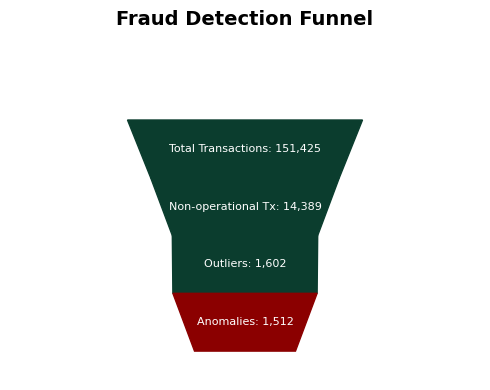

In [267]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon

labels = [
    "Total Transactions",
    "Non-operational Tx",
    "Outliers",
    "Anomalies"
]

values = np.array([151425, 14389, 1602, 1512])

colors = ["#0B3D2E", "#0B3D2E", "#0B3D2E", "#8B0000"]

# *** Log scaling for width ***
log_values = np.log10(values)
widths = log_values / log_values.max()   # normalize 0–1

plt.figure(figsize=(5, 4))
ax = plt.gca()

layer_height = 1.0
current_y = 0

for i in range(len(values)):
    top_width = widths[i]
    bottom_width = widths[i+1] if i < len(values)-1 else widths[i] * 0.7
    
    points = [
        (-top_width/2, current_y),
        ( top_width/2, current_y),
        ( bottom_width/2, current_y - layer_height),
        (-bottom_width/2, current_y - layer_height),
    ]
    
    polygon = Polygon(points, closed=True, color=colors[i])
    ax.add_patch(polygon)

    ax.text(
        0,
        current_y - layer_height/2,
        f"{labels[i]}: {values[i]:,}",
        ha="center",
        va="center",
        fontsize=8,
        color="white",
    )
    
    current_y -= layer_height

ax.set_xlim(-1, 1)
ax.set_ylim(current_y - 0.5, 1.5)
ax.axis("off")

plt.title("Fraud Detection Funnel", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


In [268]:
ml_anomalies_amount = final_df.loc[final_df['iso_flag_simple'] == 1, 'trx_amt'].sum()
print(ml_anomalies_amount)


6027490.039999999


In [269]:
import pandas as pd

df = pd.DataFrame({
    "is_outlier_flag": [0, 0, 0, 1, 1, 1, 1],
    "foreign_flag":    [0, 1, 1, 0, 1, 1, 1],
    "is_weekend_flag": [1, 0, 1, 0, 1, 0, 1],
    "iso_flag_simple": [1, 1, 1, 1, 1, 1, 1],
    "count":           [168, 402, 338, 412, 72, 109, 11]
})

df.loc["Total"] = ["-", "-", "-", "-", df["count"].sum()]

styled = df.style.set_properties(**{
    "border": "1px solid black",
    "text-align": "center"
}).set_table_styles([
    {"selector": "th", "props": [("border", "1px solid black"), ("font-weight", "bold")]}
]).highlight_max(axis=0, subset=["count"]).set_properties(subset=pd.IndexSlice["Total", :], **{
    "font-weight": "bold"
})

styled


,is_outlier_flag,foreign_flag,is_weekend_flag,iso_flag_simple,count
0,0,0,1,1,168
1,0,1,0,1,402
2,0,1,1,1,338
3,1,0,0,1,412
4,1,1,1,1,72
5,1,1,0,1,109
6,1,1,1,1,11
Total,-,-,-,-,1512


In [270]:
import pandas as pd

# --- 1. Filter ML anomalies ---
ml = comparison[comparison["iso_flag_simple"] == 1].copy()

# --- 2. Generate dynamic emoji pattern per row ---
def pattern_row(row):
    parts = []
    if row["is_outlier_flag"] == 1:
        parts.append("🔴")
    if row["foreign_flag"] == 1:
        parts.append("🌍")
    if row["is_weekend_flag"] == 1:
        parts.append("🕒")
    return " + ".join(parts) if parts else "Normal"

ml["Pattern"] = ml.apply(pattern_row, axis=1)

# --- 3. Build pattern dataframe ---
df_patterns = ml[["Pattern", "iso_flag_simple", "count", "total_amount"]].copy()

df_patterns = df_patterns.rename(columns={
    "iso_flag_simple": "ML Flag",
    "count": "Count",
    "total_amount": "Amount"
})

# --- 4. Add Total row ---
df_patterns.loc["Total"] = [
    "—",
    "—",
    df_patterns["Count"].sum(),
    df_patterns["Amount"].sum()
]

# --- 5. Create a red gradient (light → dark) ---
# Number of rows in the table
n = len(df_patterns)

# Generate gradient colors
import numpy as np

reds = np.linspace(255, 100, n).astype(int)  # light red → darkish red
colors = [f"background-color: rgb(255,{r},{r})" for r in reds]

# --- 6. Apply styling ---
styled = (
    df_patterns.style
        .apply(lambda _: colors, axis=0)  # apply gradient row-wise
        .set_properties(**{
            "color": "black",
            "background-color": "white",
            "border": "1px solid black",
            "text-align": "center"
        })
        .set_table_styles([
            {"selector": "th",
             "props": [("border", "1px solid black"), ("font-weight", "bold")]}
        ])
)

styled



,Pattern,ML Flag,Count,Amount
2,🕒,1,168,304028.000000
4,🌍,1,402,537854.900000
6,🌍 + 🕒,1,338,90337.470000
8,🔴,1,412,4073162.660000
9,🔴 + 🕒,1,72,402967.810000
10,🔴 + 🌍,1,109,554028.900000
11,🔴 + 🌍 + 🕒,1,11,65110.300000
Total,—,—,1512,6027490.040000


In [284]:
top_divisions = [
    "PARKS, FORESTRY & RECREATION",
    "TORONTO WATER",
    "ECONOMIC DEVELOPMENT & CULTURE"
]

# -------------------------------
# GROUP 1: 🔴  (Outlier only)
# -------------------------------
group1 = final_df[
    (final_df["is_outlier_flag"] == 1) &
    (final_df["foreign_flag"] == 0) &
    (final_df["is_weekend_flag"] == 0) &
    (final_df["iso_flag_simple"] == 1) &
    (final_df["division"].isin(top_divisions))
]

top3_group1 = (
    group1.sort_values("trx_amt", ascending=False)
          .groupby("division")
          .head(20)
          .sort_values(["division", "trx_amt"], ascending=[True, False])
)

print("🔴  Top 3 transactions per TOP division")
display(top3_group1[["division", "trx_amt", "merchant_name","final_merchant","purpose", "trx_dt"]])





🔴  Top 3 transactions per TOP division


,division,trx_amt,merchant_name,final_merchant,purpose,trx_dt
135651,ECONOMIC DEVELOPMENT & CULTURE,13468.54,IN ILLUMINARIUM TORON,IN ILLUMINARIUM,FUTURE MAKERS EXHIBIT,2024-10-07
42638,ECONOMIC DEVELOPMENT & CULTURE,13267.53,DOUBLETREE HOTELS,DOUBLETREE HOTELS,ACCOMMODATIONS,2023-09-15
135650,ECONOMIC DEVELOPMENT & CULTURE,11158.76,IN ILLUMINARIUM TORON,IN ILLUMINARIUM,FUTURE MAKERS EXHIBIT,2024-10-04
22991,ECONOMIC DEVELOPMENT & CULTURE,8043.75,SILVERSEA 1,SILVERSEA,NUIT BLANCHE: ARTIST TRAVEL / RESIDENCY,2023-07-28
129768,ECONOMIC DEVELOPMENT & CULTURE,7465.44,CHARTWELLS-HUMBER-2703,CHARTWELLSHUMBER,CATERING SERVICES - HUMBER,2024-10-22
164638,ECONOMIC DEVELOPMENT & CULTURE,5876.00,DRIFTSCAPE,DRIFTSCAPE,ArtworxTO content hosting on website,2025-02-04
55187,ECONOMIC DEVELOPMENT & CULTURE,5876.00,DRIFTSCAPE,DRIFTSCAPE,ARTISTIC SERVICES FOR ARTWORXTO TOURS,2023-12-08
157769,ECONOMIC DEVELOPMENT & CULTURE,5876.00,DRIFTSCAPE,DRIFTSCAPE,MOBILE AND WEB: HOSTED SEL,2025-01-02
56890,"PARKS, FORESTRY & RECREATION",9990.00,TORONTO AND REGION CON,TORONTO AND,EMERG PERMIT FEES TO GAIN ACCESS TO REPAIR BRO...,2023-12-08
64914,"PARKS, FORESTRY & RECREATION",8765.14,THE SHOP INDUSTRIAL IN,SHOP INDUSTRIAL,PARTS,2024-01-09


In [279]:
final_df.columns

Index(['division', 'trx_id', 'trx_dt', 'merchant_name', 'trx_amt',
       'trx_currency', 'original_amt', 'original_currency', 'gl_account_desc',
       'merchant_type', 'merchant_type_desc', 'purpose', 'source_file',
       'year_month', 'month_num', 'month_name', 'weekday', 'is_weekend',
       'is_foreign', 'merchant_clean', 'brand_prefix2', 'final_merchant',
       'z_score', 'outlier', 'weekday_name', 'is_weekend_flag',
       'is_outlier_flag', 'foreign_flag', 'iso_pred_simple', 'iso_flag_simple',
       'iso_score_simple', 'division_median', 'division_median_diff',
       'merchant_freq', 'merchant_freq_log', 'iso_pred_adv', 'iso_flag_adv',
       'iso_score_adv', 'is_zscore', 'is_business', 'blacklist_flag'],
      dtype='object')

In [282]:

# -------------------------------
# GROUP 2: 🔴 + 🌍 + 🕒
# -------------------------------
group2 = final_df[
    (final_df["is_outlier_flag"] == 1) &
    (final_df["foreign_flag"] == 1) &
    (final_df["is_weekend_flag"] == 1) &
    (final_df["iso_flag_simple"] == 1) &
    (final_df["division"].isin(top_divisions))
]

top3_group2 = (
    group2.sort_values("trx_amt", ascending=False)
          .groupby("division")
          .head(10)
          .sort_values(["division", "trx_amt"], ascending=[True, False])
)

print("\n🔴 + 🌍 + 🕒  Top 3 transactions per TOP division")
display(top3_group2[["division", "trx_amt", "merchant_name","final_merchant","purpose", "trx_dt"]])


🔴 + 🌍 + 🕒  Top 3 transactions per TOP division


,division,trx_amt,merchant_name,final_merchant,purpose,trx_dt
96191,ECONOMIC DEVELOPMENT & CULTURE,13154.87,EXECUTIVE LA LIMOUSINE,EXECUTIVE LA,LA GROUND TRANSPORTATION,2024-05-04
144999,ECONOMIC DEVELOPMENT & CULTURE,7302.10,"FORMASSEMBLY, INC",FORMASSEMBLY INC,RENEWAL OF SALESFORCE PLUGIN FOR APPLICATION,2024-12-14
31174,ECONOMIC DEVELOPMENT & CULTURE,4688.01,DTN,DTN,WEATHER MONITORING SERVICE,2023-09-23
47839,ECONOMIC DEVELOPMENT & CULTURE,3574.13,DTN,DTN,WEATHER MONITORING SERVICE,2023-11-25
759,ECONOMIC DEVELOPMENT & CULTURE,3517.22,DTN,DTN,WEATHER MONITORING SERVICE,2023-05-13


In [276]:
# --- Group 2: 🔴 + 🌍 + 🕒 ---
group2 = final_df[
    (final_df["is_outlier_flag"] == 1) &
    (final_df["foreign_flag"] == 1) &
    (final_df["is_weekend_flag"] == 1) &
    (final_df["iso_flag_simple"] == 1)
]

top3_group2 = (
    group2.sort_values("trx_amt", ascending=False)
          .groupby("division")
          .head(3)
          .sort_values(["division", "trx_amt"], ascending=[True, False])
)

print("\n🔴 + 🌍 + 🕒  Top 3 transactions per division")
top3_group2[["division", "trx_amt", "final_merchant", "trx_dt"]]



🔴 + 🌍 + 🕒  Top 3 transactions per division


,division,trx_amt,final_merchant,trx_dt
59179,CITY CLERKS OFFICE,4479.58,UDEMY ONLINE,2023-12-16
96191,ECONOMIC DEVELOPMENT & CULTURE,13154.87,EXECUTIVE LA,2024-05-04
144999,ECONOMIC DEVELOPMENT & CULTURE,7302.10,FORMASSEMBLY INC,2024-12-14
31174,ECONOMIC DEVELOPMENT & CULTURE,4688.01,DTN,2023-09-23
97242,FIRE SERVICES,6985.53,NFPA NATL,2024-06-15
146652,PUBLIC HEALTH,8335.05,UW PCRP,2024-12-21
167755,PUBLIC HEALTH,6071.64,UW PCRP,2025-03-22
112933,REAL ESTATE SERVICES,3490.38,PPS INC,2024-08-25
148428,TECHNOLOGY SERVICES,3511.79,SALESFORCECOM,2024-12-22


In [272]:
blacklist_keywords = [
    # Entertainment
    "NETFLIX", "DISNEY", "SPOTIFY", "YOUTUBE", "HULU", "CRAVE", 
    "XBOX", "PLAYSTATION", "STEAM",

    # Dating
    "TINDER", "BUMBLE", "HINGE", "MATCH",

    # Alcohol
    "LCBO", "BEER STORE", "WINERY", "ALCOHOL", "PUB", "BAR",

    # Gambling
    "LOTTO", "OLG", "BET", "CASINO",

    # Adult content (generic)
    "ADULT", "XXX"
]

def is_blacklisted(merchant):
    merchant = str(merchant).upper()
    return any(keyword in merchant for keyword in blacklist_keywords)

final_df["blacklist_flag"] = final_df["final_merchant"].apply(is_blacklisted)


In [273]:
relevant_cols = ["year_month",
    "trx_amt",
    "original_currency",
    "division",
    "gl_account_desc",
    "merchant_type_desc",
    "final_merchant",
    "purpose",
    "outlier",
    "is_weekend_flag",
    "is_outlier_flag",
    "foreign_flag",
    "iso_flag_simple",
    "iso_score_simple"
]

In [274]:
blacklisted_df = final_df[
    (final_df["blacklist_flag"] == True)][relevant_cols]
blacklisted_df.head(50)

,year_month,trx_amt,original_currency,division,gl_account_desc,merchant_type_desc,final_merchant,purpose,outlier,is_weekend_flag,is_outlier_flag,foreign_flag,iso_flag_simple,iso_score_simple
228,2023-05,1778.76,CAD,LEGAL SERVICES,TRAINING & DEVELOPMENT - EXTERNAL,"Organizations, Charitable and Social Ser",ONTARIO BAR,**MORE** SEM-ANNUAL UPDATE ON HUMAN RIGHTS,no,0,0,0,0,0.158546
263,2023-05,120.91,CAD,LEGAL SERVICES,TRAINING & DEVELOPMENT - EXTERNAL,"Organizations, Charitable and Social Ser",ONTARIO BAR,SEM-CASE LAW UPDATE,no,1,0,0,0,0.113017
665,2023-05,23.72,CAD,LONG-TERM CARE HOMES & SERVICES,RECREATIONAL & EDUCATIONAL SUPPLIES,Direct Marketing - Continuity/Subscripti,NETFLIXCOM,STREAMING SERVICES,no,0,0,0,0,0.317858
876,2023-05,90.38,CAD,"PARKS, FORESTRY & RECREATION",RECREATIONAL & EDUCATIONAL SUPPLIES,Swimming Pools - Sales and Supplies,BETZ,THERMOMTER FOR TPH WATER SAMPLING PROCEDURES,no,0,0,0,0,0.317617
1149,2023-05,962.61,CAD,CITY CLERKS OFFICE,RECEPTIONS & PUBLIC RELATIONS,Caterers,PICKLE BARREL,"SANDWICHES, FRUIT PAM MCCONNELL UNVEILING AND ...",no,1,0,0,0,0.028415
1301,2023-05,2728.16,CAD,REAL ESTATE SERVICES,CONTR SRV #APPLIANCE,Commercial Equipment Not Elsewhere Class,HOBART FOOD,APPLIANCE SERVICE FOR EVENT SPACE,no,0,0,0,0,0.095472
1461,2023-05,406.80,CAD,SOLID WASTE MANAGEMENT,CONFERENCES/SEMINARS - REGISTRATION FEES,"Organizations, Charitable and Social Ser",AMERICAN PUBLIC,OPWA CONFERENCE REGISTRATION,no,0,0,0,0,0.286120
1641,2023-05,282.50,CAD,TRANSPORTATION,CONSULTING SVCS-TECHNICAL,Construction Materials Not Elsewhere Cla,BARRICADE TRAFFIC,TRAFFIC MANAGEMENT PLAN,no,0,0,0,0,0.297917
2142,2023-05,922.08,CAD,ECONOMIC DEVELOPMENT & CULTURE,BOOK & MAGAZINE SUBSCRIPTIONS,Computer Software Stores,PAYPAL BETTER,VOLUNTEER IMACT ENTERPRISE EDITIONS ANNUAL SUB...,no,0,0,0,0,0.225286
2599,2023-05,165.00,CAD,PUBLIC HEALTH,MEMBERSHIP FEES,"Organizations, Charitable and Social Ser",ONTARIO PUBLIC,MEMBERSHIP FEES,no,0,0,0,0,0.314132
